# Garden Path Sentences in OpenAI Transformer Model
#### Benjamin Newman - blnewman@stanford.edu

This notebook takes a quick look at the syntactic abilities of the model proposed in Recford et al.'s paper ["Improving Language Understanding by Generative Pretraining"](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf). Their model is a transformer-based and attempts to create a universal representation for language that can be fine-tuned later for task-specific tasks. 

Transformational architectures have shown promise in parsing [Kitaev & Klein, 2018](https://arxiv.org/abs/1805.01052) and BERT has been shown to perform very well at syntactic tasks as well [Goldberg, 2019](https://arxiv.org/pdf/1901.05287.pdf), and I thought it would be interesting to look at how this particular one deals with garden path sentences. Goldberg's write-up focussed solely on BERT, but unfortunately (or fortunately for it) BERT is a bidirectional language model. This changes the meaning of surprisal and perplexity, and as these are the basis for the observations described here, so such bidirectional models are avoided.

Garden path sentences are usually studied in the psycholinguistics literature when asking questions about how humans parse natural language. They are sentences that at first present a relatively innocuous parsing problem but then suddenly confuse the reader. Some examples include:

- "The old man the boat"
- "The horse raced past the barn fell"
- "The child pushed through the crowd cried for his mother"

One of the more common ways to create these kinds of sentences is to start with a sentence with a relative clause and drop the "that" forming a reduced relative clause. For example, "the horse *that* raced past the barn fell" become "the horse raced past the barn fell." The past participle and the past tense have to be the same form and the verb should ideally be one that could easily be construed to take a subject.

This write-up was also inspired by [Hale et al., 2018](https://arxiv.org/pdf/1806.04127.pdf)'s work showing that information-theoretic measurements from the beam of a Recurrent Neural Network Grammars (RNNG) parser correlates with EEG results in humans. They were able to demonstrate that high surprisal co-occured with early EEG effects and parser distance co-occured with P600 effects in human listeners. These are effects correlated with grammatical mistakes are difficulties in humans. Also very much related is [Schijndel & Linzen, 2018](http://tallinzen.net/media/papers/van_schijndel_linzen_2018_cogsci.pdf). They find surprisal calculated from different models is not quite enough to make up for the increased reading times in garden path sentences by humans.

The code is all below. The OpenAI UGP model and weights were downloaded from [here](https://github.com/huggingface/pytorch-openai-transformer-lm).


In [16]:
from model_pytorch import TransformerModel, load_openai_pretrained_model, DEFAULT_CONFIG, LMModel
import torch
import math
import numpy as np
from matplotlib import pyplot as plt
from text_utils import TextEncoder

In [741]:
#import model_pytorch
importlib.reload(model_pytorch)

<module 'model_pytorch' from '/Users/benjaminnewman/Documents/Machine Learning/Linguistics/openai-transformer-lm/pytorch-openai-transformer-lm/model_pytorch.py'>

In [742]:
from model_pytorch import TransformerModel, load_openai_pretrained_model, DEFAULT_CONFIG, LMModel

In [4]:
# set up the encoder to turn words into indices
encoder_path = 'model/encoder_bpe_40000.json'
bpe_path = 'model/vocab_40000.bpe'

text_encoder = TextEncoder(encoder_path, bpe_path)

nvocab = len(text_encoder.encoder)
nctx = 512 # number of positional embeddings? (nctx = number of context)
vocab = nvocab + nctx

In [743]:
# load language modeling model with default arguments except return_probs set to true
# so we can get access to language model probabilities to calculate perplexity and surprisal
args = DEFAULT_CONFIG
lm_model = LMModel(args, vocab, nctx, return_probs = True)
load_openai_pretrained_model(lm_model.transformer, n_ctx=nctx, n_special=0)

lm_model.eval()

HELLO THERE!
Loading weights...


LMModel(
  (transformer): TransformerModel(
    (embed): Embedding(40990, 768)
    (drop): Dropout(p=0.1)
    (h): ModuleList(
      (0): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln_1): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1)
        )
        (ln_2): LayerNorm()
      )
      (1): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln_1): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1)
        )
        (ln_2): LayerNorm()
      )
      (2): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
      

In [11]:
# make_batch from generate.py in the huggingface repo
# generates the input to the language model from a list of token ids (X)

def make_batch(X):
    X = np.array(X)
    assert X.ndim in [1, 2]
    if X.ndim == 1:
        X = np.expand_dims(X, axis=0)
    # add positional encodings - just second dimension that says which word is where
    pos_enc = np.arange(nvocab, nvocab + X.shape[-1])
    pos_enc = np.expand_dims(pos_enc, axis=0)
    batch = np.stack([X, pos_enc], axis=-1)
    batch = torch.tensor(batch, dtype=torch.long)
    return batch

In [771]:
sent = "I am a cow"

In [772]:
X = np.array(text_encoder.encode([sent]))

In [885]:
text_encoder.encode(["I am a cow ."])

[[249, 1048, 246, 9781, 239]]

In [773]:
X

array([[ 249, 1048,  246, 9781]])

In [774]:
nvocab

40478

In [779]:
np.arange(nvocab, nvocab + X.shape[-1])

array([40478, 40479, 40480, 40481])

In [786]:
pos_enc = np.expand_dims(np.arange(nvocab, nvocab + X.shape[-1]), axis=0)

In [789]:
torch.tensor(np.stack([X, pos_enc], axis=-1), dtype=torch.long)

tensor([[[  249, 40478],
         [ 1048, 40479],
         [  246, 40480],
         [ 9781, 40481]]])

In [791]:
X_tens = torch.tensor(np.stack([X, pos_enc], axis=-1), dtype=torch.long)

In [802]:
X_tens.size()

torch.Size([1, 4, 2])

In [803]:
X_tens.view(-1, X_tens.size(-2), X_tens.size(-1))

tensor([[[  249, 40478],
         [ 1048, 40479],
         [  246, 40480],
         [ 9781, 40481]]])

In [805]:
e = lm_model.transformer.embed(X_tens)

In [806]:
e

tensor([[[[-0.0633, -0.0310,  0.0090,  ...,  0.0139, -0.0252,  0.0283],
          [-0.0003, -0.0119,  0.0015,  ..., -0.0003,  0.0153, -0.0087]],

         [[ 0.0189, -0.0330, -0.0029,  ..., -0.0477,  0.0050,  0.0155],
          [-0.0148,  0.0320, -0.0180,  ...,  0.0242, -0.0592,  0.0265]],

         [[ 0.0129,  0.0418, -0.0141,  ...,  0.0133, -0.0342,  0.0160],
          [-0.0059,  0.0059, -0.0142,  ...,  0.0016, -0.0215,  0.0069]],

         [[-0.0774,  0.0292,  0.0138,  ...,  0.0294,  0.0348,  0.0339],
          [-0.0167, -0.0075, -0.0125,  ..., -0.0102, -0.0194, -0.0083]]]],
       grad_fn=<EmbeddingBackward>)

In [811]:
e.size()

torch.Size([1, 4, 2, 768])

In [848]:
h_in = e.sum(dim=2)

In [849]:
h_in.split(768, dim=2)

(tensor([[[-0.0637, -0.0429,  0.0105,  ...,  0.0137, -0.0098,  0.0197],
          [ 0.0042, -0.0011, -0.0209,  ..., -0.0235, -0.0542,  0.0420],
          [ 0.0071,  0.0477, -0.0283,  ...,  0.0150, -0.0557,  0.0228],
          [-0.0941,  0.0217,  0.0013,  ...,  0.0192,  0.0154,  0.0256]]],
        grad_fn=<SplitBackward>),)

In [855]:
pos_emb_mask = torch.zeros(1, 1, 100)
pos_emb_mask[:, :, -10:] = -1e12

In [856]:
pos_emb_mask

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0

In [816]:
torch.tril(torch.ones(4, 4)).view(1, 1, 4, 4)

tensor([[[[1., 0., 0., 0.],
          [1., 1., 0., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 1.]]]])

In [815]:
torch.ones(4, 4)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [819]:
torch.empty(4, 4)

tensor([[ 0.0000e+00, -8.5899e+09,  1.6879e+38, -3.6902e+19],
        [ 1.3411e-05,  3.3736e-06,  6.5562e-10,  6.8993e-07],
        [ 1.3384e+22,  2.1864e+23,  2.1574e-04, -1.5781e-38],
        [ 3.7020e-40,  2.1574e-04,  1.5781e-38,  3.7020e-40]])

In [820]:
torch.addmm

<function _VariableFunctions.addmm>

surprisals: [5.935112210581368, 4.403716275950978, 13.498449721123247, 6.826212627475763, 6.278461020069237, 2.8444631077265, 2.7839442445733744, 4.023768383053921, 1.5085484664259168, 5.423116432981172, 6.91220909362173, 14.978258022036943, 4.202760013027399, 2.6376851845596483, 4.7791483337667255, 20.014431372368552]
perplexities: [133.57057223672896, 232.87952363902878, 1276.9289818447944, 22.125301040120927, 176.84352212274018, 15.950812582743378, 92.87525075912183, 661.2078845729322, 14.045026694439406, 33.60489871718207, 634.325965405133, 116.23900575207361, 49.337305214654265, 34.337250588477474, 934.8318099050775, 12.254558702671725]


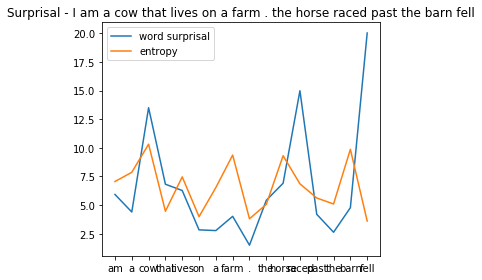

In [837]:
plot_pp_surp("I am a cow that lives on a farm . the horse raced past the barn fell")

surprisals: [5.935112210581368, 4.403716275950978, 13.498449721123247, 6.826212627475763, 6.278461020069237, 2.8444631077265, 2.7839442445733744, 4.023768383053921, 1.5085484664259168, 5.423116432981172, 6.91220909362173, 4.755514939926704, 14.065489800933829, 4.550178437918932, 3.882287312176683, 4.501481631411127, 11.198152140897337]
perplexities: [133.57057223672896, 232.87952363902878, 1276.9289818447944, 22.125301040120927, 176.84352212274018, 15.950812582743378, 92.87525075912183, 661.2078845729322, 14.045026694439406, 33.60489871718207, 634.325965405133, 116.23900575207361, 185.046223424654, 53.73666082170711, 30.80952893703012, 668.60819202491, 70.86198986141287]


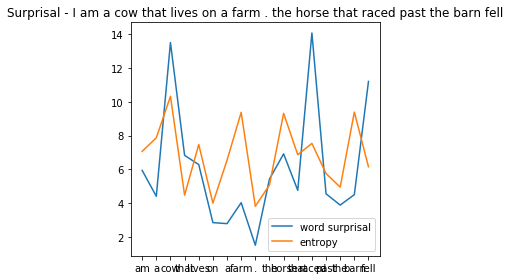

In [838]:
plot_pp_surp("I am a cow that lives on a farm . the horse that raced past the barn fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
perplexities: [2696.0325628993974, 151.3371317456799, 222.2516777071844, 46.74033217217957, 33.62912943000506, 975.0484886984677, 14.171326395798566]


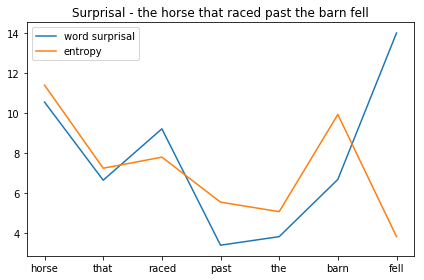

In [839]:
plot_pp_surp("the horse that raced past the barn fell")

In [824]:
get_top_k_nw("I am a cow. The students")

I am a cow. The students
	...are</w> (0.1608)
	...of</w> (0.0435)
	...have</w> (0.0421)
	...do</w> (0.0363)
	...will</w> (0.0342)
	...at</w> (0.0333)
	...and</w> (0.0278)
	...in</w> (0.0263)
	...who</w> (0.0245)
	...love</w> (0.0234)


(array([0.16082035, 0.04352795, 0.0421225 , 0.03626319, 0.03417706,
        0.03328962, 0.02782045, 0.0262928 , 0.0244874 , 0.02335279],
       dtype=float32),
 ['are', 'of', 'have', 'do', 'will', 'at', 'and', 'in', 'who', 'love'],
 [tensor([[[-5.6609e-02,  1.2341e-02,  5.5677e-02,  ...,  2.0777e-01,
            -7.0827e-02,  1.6042e-02],
           [-2.9449e-02,  2.1994e-02, -2.3954e-02,  ...,  1.0111e-01,
            -3.3709e-02,  1.5012e-02],
           [-6.8822e-02,  3.7202e-02, -3.2227e-03,  ...,  6.0648e-02,
            -2.8242e-02, -1.2025e-04],
           ...,
           [-5.3078e-02, -7.1456e-03, -1.5571e-03,  ..., -2.3127e-02,
             1.3577e-02,  5.0389e-02],
           [-2.6138e-02,  3.0795e-03, -3.4349e-04,  ...,  2.7915e-02,
            -3.2861e-02,  4.5740e-03],
           [ 2.4230e-02, -8.6668e-03,  1.1271e-02,  ...,  5.1530e-02,
            -7.3854e-03, -8.0163e-03]]], grad_fn=<ViewBackward>),
  tensor([[[ 0.0051,  0.0065, -0.0323,  ...,  0.0027, -0.0325, -0.0389]

In [860]:
get_top_k_nw("I went to the track near the farm. the horse raced past the barn")

I went to the track near the farm. the horse raced past the barn
	...,</w> (0.3433)
	...and</w> (0.3102)
	....</w> (0.0712)
	...with</w> (0.0272)
	...as</w> (0.0188)
	...to</w> (0.0185)
	...at</w> (0.0163)
	...where</w> (0.0138)
	...in</w> (0.0138)
	...on</w> (0.0130)


(array([0.3433377 , 0.31016055, 0.07121104, 0.02723882, 0.01875766,
        0.01850431, 0.01625536, 0.01381128, 0.0137872 , 0.01297225],
       dtype=float32),
 [',', 'and', '.', 'with', 'as', 'to', 'at', 'where', 'in', 'on'],
 [tensor([[[-0.0566,  0.0123,  0.0557,  ...,  0.2078, -0.0708,  0.0160],
           [-0.0708,  0.0104, -0.0074,  ...,  0.1224, -0.0588,  0.0080],
           [-0.1129,  0.0108, -0.0033,  ...,  0.0487, -0.0201, -0.0079],
           ...,
           [ 0.0295, -0.0348,  0.0243,  ..., -0.0424, -0.0140, -0.0744],
           [ 0.0110, -0.0300,  0.0239,  ..., -0.0755, -0.0293, -0.0373],
           [ 0.0377, -0.0495,  0.0221,  ..., -0.0680, -0.0725, -0.0660]]],
         grad_fn=<ViewBackward>),
  tensor([[[ 0.0051,  0.0065, -0.0323,  ...,  0.0027, -0.0325, -0.0389],
           [-0.0372,  0.0146, -0.0292,  ...,  0.0175, -0.0439, -0.0414],
           [-0.0417,  0.0186, -0.0531,  ...,  0.0177, -0.0679, -0.0735],
           ...,
           [ 0.2162, -0.0842,  0.1629,  ..., -0.

In [859]:
get_top_k_nw("I went to the track near the farm. the horse that raced past the barn")

I went to the track near the farm. the horse that raced past the barn
	...was</w> (0.4353)
	...had</w> (0.0662)
	...,</w> (0.0364)
	...and</w> (0.0348)
	...looked</w> (0.0231)
	...stopped</w> (0.0214)
	...in</w> (0.0158)
	...did</w> (0.0145)
	...on</w> (0.0112)
	...at</w> (0.0107)


(array([0.43532425, 0.06615921, 0.03641997, 0.03475316, 0.02310109,
        0.0214009 , 0.01583237, 0.01445351, 0.01124712, 0.01074546],
       dtype=float32),
 ['was', 'had', ',', 'and', 'looked', 'stopped', 'in', 'did', 'on', 'at'],
 [tensor([[[-0.0566,  0.0123,  0.0557,  ...,  0.2078, -0.0708,  0.0160],
           [-0.0708,  0.0104, -0.0074,  ...,  0.1224, -0.0588,  0.0080],
           [-0.1129,  0.0108, -0.0033,  ...,  0.0487, -0.0201, -0.0079],
           ...,
           [ 0.0238, -0.0279,  0.0195,  ..., -0.0505, -0.0115, -0.0669],
           [ 0.0096, -0.0266,  0.0206,  ..., -0.0816, -0.0282, -0.0342],
           [ 0.0379, -0.0480,  0.0201,  ..., -0.0693, -0.0707, -0.0663]]],
         grad_fn=<ViewBackward>),
  tensor([[[ 0.0051,  0.0065, -0.0323,  ...,  0.0027, -0.0325, -0.0389],
           [-0.0372,  0.0146, -0.0292,  ...,  0.0175, -0.0439, -0.0414],
           [-0.0417,  0.0186, -0.0531,  ...,  0.0177, -0.0679, -0.0735],
           ...,
           [ 0.1589,  0.0028,  0.1666,  

Now that all the set-up is done (that was fast!), we can start using the language model.

In [629]:
def get_top_k_nw(sent, k=10, verbose=True):
    """
    Prints out the top k most probable next word continuations of the sentence sent
    """
    sent_vec = text_encoder.encode([sent])
    sent_batch = make_batch(sent_vec)
    sent_res = lm_model(sent_batch)
#     print("things have changed:")
#     print(attn_weights)
    # get top k next words with probabilities
    probs, decode = sent_res[:,-1,:].topk(k)  
    if verbose:
        print(sent)
        for p, d in zip(probs.flatten(), decode.flatten()):
            print("\t...%s (%.4f)"%(text_encoder.decoder[d.item()], p.item()))
    
    words = [text_encoder.decoder[d.item()] for d in decode.flatten()]
    for i in range(len(words)):
        if words[i][-4:] == "</w>":
            words[i] = words[i][:-4]
    return probs.flatten().detach().numpy(), words, lm_model.transformer.attn_weights
        
    

Now we can see it in action. The <\w\> at the end signify the end of legal words

In [632]:
_, _, attn_weights = get_top_k_nw("I am a", 8, False)

In [1140]:
get_surprisal("The horse raced past the barn fell".split(" "))

([10.54796505332892,
  10.345239978589484,
  4.759155399114188,
  2.410015756747987,
  6.638949901119871,
  19.997773855146455],
 [tensor([[5.7855e-07, 1.1202e-05, 2.3162e-09,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[6.2616e-07, 8.0263e-06, 8.7403e-11,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[3.1936e-08, 9.8063e-07, 5.5878e-12,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[1.2472e-07, 1.5449e-06, 1.1615e-10,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[4.9516e-08, 5.0566e-06, 1.1018e-09,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[1.4577e-08, 6.0204e-07, 2.2289e-12,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], grad_fn=<SliceBackward>),
  tensor([[2.3750e-08, 3.9498e-06, 1.0985e-11,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00]], g

In [1136]:
def get_surprisal(sentence):
    """
    sentences is a list of words. 
    Calculates the surprisal, -log p(w), of each word in the sentence
    """
    surprisals = []
    all_probs = []
    for i in range(1, len(sentence) + 1):
        partial_sent = [" ".join(sentence[:i])]
        
        
        partial_vec = text_encoder.encode(partial_sent)
        partial_batch = make_batch(partial_vec)
        partial_res = lm_model(partial_batch)
        
        # get probabilitiy of next word 
        if i < len(sentence):
            next_word = sentence[i]
            next_word_ind = text_encoder.encoder['%s</w>'%(next_word)] # get index of word in encoder
            next_word_prob = partial_res[:,-1,next_word_ind]
           

        all_probs.append(partial_res[:,-1,:]) # keep track of probs after ith word

        
        if i < len(sentence):
            surprisals.append(-math.log2(next_word_prob))
    return surprisals, all_probs

From the psycholinguistics literature, we would expect that words that trigger the garden path effect (i.e. "fell" in "The horse raced past the barn fell"--the word where people get confused) to have a very high surprisal associated with it.

Also, the surprisal of the first word of the sentence isn't calculated because there is nothing to condition on.
we could modify this to use the start token, but because the garden path effect onset is never at the beginning
of sentence, we decide to forgo this.

In [187]:
sent_list = "The horse raced past the barn fell".split()
surprisals, probs = get_surprisal(sent_list)
print(surprisals)

[10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]


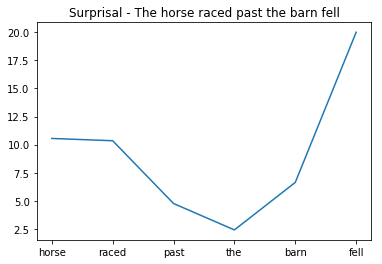

In [188]:
plt.plot(range(1,len(sent_list)), surprisals)
plt.xticks(range(1,len(sent_list)), sent_list[1:])
plt.title("Surprisal - The horse raced past the barn fell")
plt.show()

Indeed that is what we predict! The surprisal of "fell" is much higher than the rest of the words in the sentence indicating that it was very unexpected. A quick sanity check that let's us know this is working correctly is looking at the surprisal of the word "the", a common word, and has a low surprisal. Sweet!

Now, we can compare this to the disambiguated sentence:

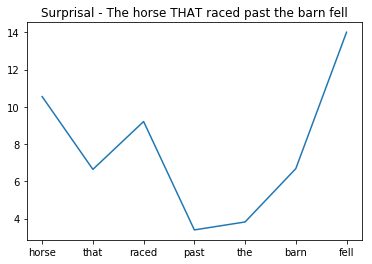

In [344]:
sent_list = "The horse that raced past the barn fell".split()
surprisals, probs = get_surprisal(sent_list)
plt.plot(range(1,len(sent_list)), surprisals)
plt.xticks(range(1,len(sent_list)), sent_list[1:])
plt.title("Surprisal - The horse THAT raced past the barn fell")
plt.show()

Interestingly, we still see a spike in surprisal of the word "fell". It is not quite as high, perhaps indicating that the model is taking into account something of the syntax. Maybe the sentence ending words did not rank as probable in this version of the language model, for instance. That said it is still quite high. Additionally, there is another spike in surprisal after the word "that". The magnitude of this surprisal is not huge, but it is definitely there. A similar effect can be found by looking at the word "barn"--relative to the words to its left, it has a high surprisal. These surprisals are not originating from the syntax--"that raced" is a perfectly syntactically valid construction. They must be evidence of a different kind of ambiguity. There are so many words that can follow the word "that"! Why should "raced" be any more common than "ate"? Similarly, why should "barn" be preferable to "field" or "finish line"? 

We need to take into account how many good possible options we have for the next word, and to do that we can use the measure of __perplexity__.


Perplexity, as Dan Jurafsky describes it, is akin to the "average branching factor" of a model has to consider when predicting the next word. If the perplexity of high, there are many choices for next words with similar probabilities, so it is more difficult for the model to predict what comes next. On the other hand, if the perplexity is low, then the model is pretty confident about the next word. The actual equation used to calculate perplexity is the exponentiation of the entropy:

$$ 2^{H(p)} $$

Where $H(p)$ is the information-theoretic entropy of the distribution, or the average surprisal:

$$H(p) = -\sum_{w \in V} p(w)\cdot log(p(w))$$

So, if we calculate surprisal and perplexity at every point in our sentence, we can get a sense of how "surprising" a word is compared to how surprising we expected it to be:
- If both are high, then we had a lot of probable options and just chose one, not super informative. 
- If both are low, we did not have a lot of probable options and just chose one that was very common. 
- If perplexity is high, and surprisal is low, that would be kind of strange, because we have a lot of possible options, but perhaps the one we chose was more probable than the others. 
- Finally, if perplexity is low and surprisal is high, then we did not have a lot of different probable option (i.e. we kind of knew what was coming next), but the next word was still very informative and unexpected.

The last case neatly lines up with our garden path effect! We think we know where a sentence is going, but suddely it ends up somewhere else. Let's take another look at our surprisals in light of this disucssion.

In [190]:
def perplexity(probs):
    """
    probs is a torch tensor, so we have to convert it to a numpy array and detach the gradient
    """
    entropy = sum(p * np.log2(p) if p > 0 else 0 for p in probs.detach().numpy())
    return 2 ** -entropy

In [718]:
def entropy(probs):
    return -sum(p * np.log2(p) if p > 0 else 0 for p in probs.detach().numpy())

In [941]:
def get_surp_entropy_ratio(sent):
    sent = sent.split(" ")
    surprisals, probabilities = get_surprisal(sent)
    hs = [entropy(prob_dist.flatten()) for prob_dist in probabilities[:-1]]
    return np.array(surprisals)/np.array(hs)
    

In [720]:
get_surp_entropy_ratio("The horse raced past the barn fell")

array([0.92553433, 1.42858046, 0.87449752, 0.46187417, 0.63786697,
       5.74753783])

In [998]:
def plot_pp_surp(sent):
    """
    plot the incremental perplexity and surprisal of a given sentence underneath each other
    """
    sent = sent.split(" ")
    surprisals, probabilities = get_surprisal(sent)
    pps = [perplexity(prob_dist.flatten()) for prob_dist in probabilities]
    ents = [entropy(prob_dist.flatten()) for prob_dist in probabilities]
    print("surprisals:", surprisals)
    print("entropies:", np.log2(pps[:-1]))
    print("entropies2:", ents)
    # graphing
    # pp subplot - shifted one to right to get perplexity AT word (want to know: when we 
    # chose this word, what was the average branching factor? or how hard should it have been to choose this word?)
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(sent)), surprisals/np.array(ents[:-1]), label="ratio")
    # plt.plot(range(1, len(sent)), np.power(2, surprisals), label="word")
    plt.xticks(range(1, len(sent)), sent[1:])
    #plt.ylim(0, 1500)
    plt.legend()
    plt.title("surprisal - entropy ratio - %s"%(" ".join(sent)))
    
    # surprisal subplot
    plt.subplot(2, 1, 2)
    #plt.subplot(1, 1, 1)
    plt.plot(range(1, len(sent)), surprisals, label="word surprisal")
    plt.plot(range(1, len(sent)), np.log2(pps[:-1]), label="entropy")
    plt.xticks(range(1, len(sent)), sent[1:])
    plt.legend()
    plt.title("Surprisal - %s"%(" ".join(sent)))
    
    plt.tight_layout() # avoids overlap
    plt.show()

surprisals: [10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]
entropies: [11.39662221  7.2416222   5.44215994  5.2179055  10.40804774  3.47936359]
entropies2: [11.396622206274504, 7.241622197243004, 5.442159941908, 5.2179055045488445, 10.408047738372169, 3.479363588235967, 5.327099568560152]


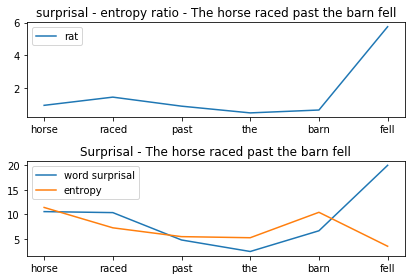

In [997]:
plot_pp_surp("The horse raced past the barn fell")

There we go! Now we can see that the surprisal increase at "barn" was somewhat warrented, as there was a high perplexity, so many words were likely to be chosen. However, for the word "fell", there was a low perplexity, but a high surprisal--exactly what we said we expected for a garden path effect.

Note: the perplexity of a word is the perplexity BEFORE the word was chosen. i.e. when deciding that the next word was "barn" after "the" there were many words assigned even probabilities, but "barn" was the one chosen.\

Also plotted on the surprisal graph is the average surprisal, or entropy, which is the log2 of perplexity

Let's see how this compares to the version of this sentence without the effect:

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 5.366152952284609]


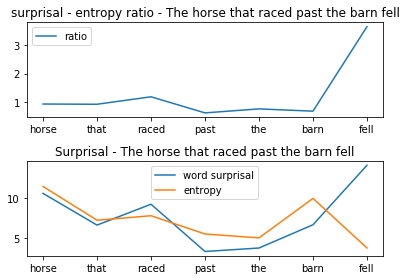

In [999]:
plot_pp_surp("The horse that raced past the barn fell")

Huh, so we see a very similar effect. After the word "that" we have slight increase in perplexity that is somewhat matched by the surprisal of "raced" (but even that has a relatively high surprisal). Interestingly, the word "fell" still has a high surprisal even though the perplexity is relatively low. Is this an example of failure to learn or take into account syntax? Or is "fell" just a very infrequent word in this context?

Another way we could look at the difference between these two distributions is by calculating the KL-Divergence

In [345]:
def cross_entropy(p, q):
    return -sum(p[i] * np.log2(q[i]) if q[i] != 0 else 0 for i in range(len(p)))

In [346]:
def kl_div(p, q):
    return cross_entropy(p, q) - cross_entropy(p, p)

In [288]:
# test
p = [0.25, 0.25, 0.25, 0.25]
q = [0.49, 0.49, 0.01, 0.01]
cross_entropy(p, q)

3.8365012677171206

In [231]:
sent1 = "The horse raced past the barn fell".split(" ")
sent2 = "The horse that raced past the barn fell".split(" ")
sp1, p1 = get_surprisal(sent1)
sp2, p2 = get_surprisal(sent2)

In [277]:
p1_np = [p.detach().numpy().flatten() for p in p1]
p2_np = [p.detach().numpy().flatten() for p in p2]

In [284]:
sent1_probs = dict(zip(sent1, p1_np))
sent2_probs = dict(zip(sent2, p2_np))

In [290]:
# sent1 is the shorter garden path version so we iterate over it:
print("word\tDIV_kl(gp, ngp)\tDIV_kl(ngp gp)")
for word in sent1:
    print(word, kl_div(sent1_probs[word], sent2_probs[word]), kl_div(sent2_probs[word], sent1_probs[word]), sep="\t")

word	DIV_kl(gp, ngp)	DIV_kl(ngp gp)
The	0.0	0.0
horse	0.0	0.0
raced	0.5508232598864273	0.5704328383400252
past	0.34396030780165354	0.46240853918018576
the	0.10742160183058047	0.10866557576429337
barn	0.23600627442564726	0.42635918920371374
fell	0.26456649345619443	0.20935524599306277


As expected, the $Div_{KL}$ is 0 for the first two words until the word "that" in the disambiguated garden path (that  is because this model is deterministic--what would happen if it weren't?). Initially, the divergence is pretty high, but it is not too high at the garden path effect onset word "fell", which seems to indicate that the distributions over words are similar. (I don't really have a sense of scale here but relative to the other kl divergences in the sentenc, it is pretty low.

It appears that information-theoretic explanations aren't enough to reproduce the garden path effect. We can see if parts of speech are enough, though. Basically what we want to do here is take garden path sentences (both ambiguous and disambiguated) missing the last word (which is the garden path effect onset word) and use the language model to predict the most likely next ~100 words. We then take those words and extract their parts of speech using a POS tagger (I'm using spacy here). We can then see if these distributions are qualitatively different.

In [347]:
import spacy
from collections import Counter

In [348]:
nlp = spacy.load('en_core_web_sm')

In [663]:
# an example with the gp sentence "The horse raced past the barn"
sent1 = "The horse raced past the barn fell".split(" ")
#sent1 = "The man knocked".split(" ")
probs, words, _ = get_top_k_nw(" ".join(sent1[:-1]), k= 100, verbose=False)

pos_counter = Counter()

for word in words:

    pos_counter[nltk.pos_tag(sent1[:-1] + [word])[-1][1]] += 1

print(" ".join(sent1[:-1]))
pos_counter.most_common()   

The man


[('VBD', 48),
 ('IN', 15),
 ('PRP', 6),
 ('VBZ', 5),
 ('MD', 5),
 ('.', 3),
 ('NN', 3),
 ('VBG', 3),
 ('RB', 3),
 ('POS', 1),
 ('WP', 1),
 (',', 1),
 ('CC', 1),
 ('TO', 1),
 (':', 1),
 ('WP$', 1),
 ('RP', 1),
 ('DT', 1)]

In [696]:
def get_common_pos_continuation(sent, k=100, use_prob=True):
    """
    Returns a list of the parts of speech of the k most probable continuations of the sentence.
    Pass in the whole sentence and the last word is removed for you.
    
    If use_prob, then weight the counts we're adding by the probabilities (this seems to work best)
    
    sent = [The, horse, raced, past, the, barn] to get "fell"
    """
    # get distribution over top k words
    probs, words, _ = get_top_k_nw(" ".join(sent), k=k, verbose=False)

    pos_counter = Counter()

    
    for prob, word in zip(probs, words):
        encoded = nlp(" ".join(sent + [word]))
        if use_prob:
            pos_counter[encoded[-1].pos_] += prob
        else:
            pos_counter[encoded.pos_] += prob

    print(" ".join(sent))
    return pos_counter.most_common()

In [703]:
nouns = verbs
noun_probs = verb_probs

79
['door', 'room', 'way', 'man', 'world', 'floor', 'house', 'front', 'ground', 'back', 'night', 'table', 'time', 'car', 'rest', 'end', 'side', 'bed', 'wall', 'air', 'kitchen', 'top', 'moment', 'day', 'window', 'right', 'woman', 'water', 'whole', 'road', 'sun', 'place', 'phone', 'girl', 'bottom', 'fact', 'dark', 'corner', 'middle', 'truth', 'edge', 'light', 'city', 'street', 'others', 'fire', 'sky', 'crowd', 'boy', 'past', 'men', 'guy', 'morning', 'sound', 'building', 'bar', 'stairs', 'darkness', 'wind', 'office', 'people', 'book', 'walls', 'desk', 'bathroom', 'police', 'living', 'town', 'center', 'hallway', 'doorway', 'forest', 'chair', 'hall', 'hell', 'driver', 'words', 'ship', 'bedroom']


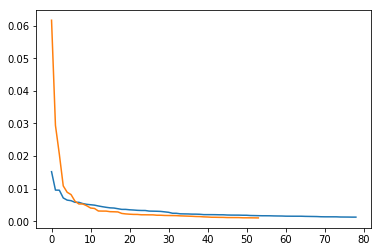

In [705]:
pos = "NOUN"
k = 100
sent = "The".split(" ")
probs, words, _ = get_top_k_nw(" ".join(sent), k=k, verbose=False)

pos_counter = Counter()

verbs = []
verb_probs = []
for prob, word in zip(probs, words):
    encoded = nlp(" ".join(sent + [word]))
    if encoded[-1].pos_ == pos:
        #print("hi")
        verbs.append(word)
        verb_probs.append(prob)
    
#     if use_prob:
#         pos_counter[encoded[-1].pos_] += prob
#     else:
#         pos_counter[encoded.pos_] += prob

# normalize
probs = np.array(verb_probs)/np.sum(verb_probs)
print (len(verb_probs))
print(verbs)
plt.plot(range(len(verb_probs)), verb_probs)
plt.plot(range(len(noun_probs)), noun_probs)
#plt.xticks(range(len(verb_probs)), verbs)

plt.show()
# calculate entropy

# print(" ".join(sent[:-1]))
# return pos_counter.most_common()

In [706]:
def get_common_pos_continuations(sents, k=100, use_prob=True):
    """
    Same as above, but can handle and concatenate multiple sentences into the same counter
    """
    pos_counter = Counter()
    
    for sent in sents:
        sent = sent.split(" ")[:-1]
        probs, words, _ = get_top_k_nw(" ".join(sent), k=k, verbose=False)



        for prob, word in zip(probs, words):
            encoded = nlp(" ".join(sent + [word]))
            if use_prob:
                pos_counter[encoded[-1].pos_] += prob
                #pos_counter[nltk.pos_tag(sent[:-1] + [word])[-1][1]] += prob
            else:
                pos_counter[encoded.pos_] += prob
                #pos_counter[nltk.pos_tag(sent[:-1] + [word])[-1][1]] += 1

    # print(" ".join(sent[:-1]))
    return pos_counter.most_common()

In [1117]:
a = (1, 2, 3)
a = list(a)
a

[1, 2, 3]

In [1125]:
sent1 = "The horse raced past the barn".split(" ")
list(list(zip(*get_common_pos_continuation(sent1, k = 100)))[0])

The horse raced past the barn


['PUNCT',
 'CCONJ',
 'ADP',
 'NOUN',
 'ADV',
 'PART',
 'VERB',
 'PRON',
 'DET',
 'ADJ',
 'NUM',
 'SPACE']

In [695]:
sent2 = "The horse that raced past the barn fell".split(" ")
get_common_pos_continuation(sent2, k=100)

The horse that raced past the barn


[('PUNCT', 0.5922014378847962),
 ('CCONJ', 0.14837942079157074),
 ('ADP', 0.131672283619082),
 ('VERB', 0.057005400993148214),
 ('NOUN', 0.02194006133959192),
 ('ADV', 0.018310591553927225),
 ('PART', 0.00614709488581866),
 ('ADJ', 0.005809091057017213),
 ('DET', 0.003585657889743743),
 ('PRON', 0.0027526504618435865),
 ('NUM', 0.000936109087888326),
 ('SPACE', 0.0003814685915131122)]

In [384]:
get_common_pos_continuation("The raft floated down the river sank".split(" "))

The raft floated down the river


[('PUNCT', 0.5331196740444284),
 ('ADP', 0.2668831846967805),
 ('CCONJ', 0.08209618390537798),
 ('ADV', 0.027353670564480126),
 ('DET', 0.013760308356722817),
 ('NOUN', 0.012272255087736994),
 ('PART', 0.010578949353657663),
 ('NUM', 0.002206007397035137),
 ('ADJ', 0.002158162329578772),
 ('VERB', 0.0006818633410148323)]

In [433]:
get_common_pos_continuation("The cotton clothing is made of burns".split(" "))

The cotton clothing is made of


[('DET', 0.20072045968845487),
 ('NOUN', 0.19488437043037266),
 ('PUNCT', 0.1099302206421271),
 ('ADJ', 0.10232447844464332),
 ('ADV', 0.015454574022442102),
 ('PRON', 0.009519345709122717),
 ('ADP', 0.00789696432184428),
 ('NUM', 0.005846542306244373),
 ('CCONJ', 0.0055710612796247005),
 ('VERB', 0.003945989650674164),
 ('INTJ', 0.0018580174073576927)]

surprisals: [7.273245396777892, 2.0318674364462534, 6.664009741217003, 6.5611623442622, 18.322569711330626]
entropies: [7.42957138 4.16542873 5.18486801 5.99692803 3.53688653]
entropies2: [7.429571383590368, 4.165428726740576, 5.18486801003132, 5.996928034095767, 3.5368865285654483, 4.586591099215322]


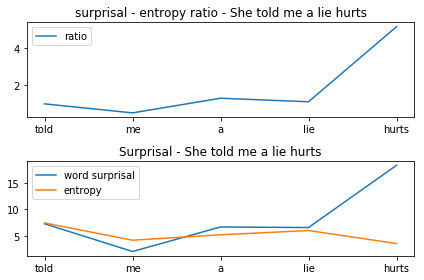

In [1000]:
plot_pp_surp("She told me a lie hurts")

surprisals: [7.273245396777892, 2.0318674364462534, 3.1455342921167415, 6.705784670080099, 11.857424066955016, 13.982311259867753]
entropies: [7.42957138 4.16542873 5.18486801 6.51660947 9.44989727 4.64953194]
entropies2: [7.429571383590368, 4.165428726740576, 5.18486801003132, 6.516609470312277, 9.449897269579505, 4.649531939856634, 4.7712699919312875]


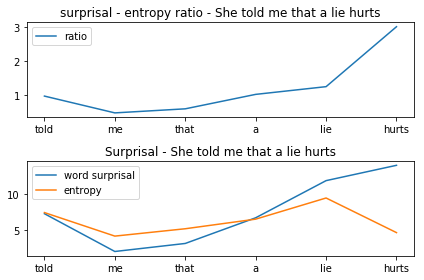

In [1001]:
plot_pp_surp("She told me that a lie hurts")

surprisals: [16.978937178101617, 8.986129929533078, 22.608651246566364, 16.537047973782894, 18.12078453487543]
entropies: [5.06460751 5.00001581 6.68384833 7.83323889 7.88008975]
entropies2: [5.0646075105158905, 5.000015810560239, 6.683848330518108, 7.833238885638901, 7.880089751822517, 6.583618006212297]


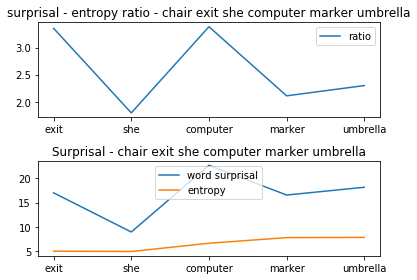

In [1002]:
# random words
plot_pp_surp("chair exit she computer marker umbrella")

surprisals: [8.789379186618037, 18.075035038645186, 17.274545013568865, 15.507002030038853]
entropies: [10.60437293  7.84195798  6.02525669  5.42011742]
entropies2: [10.604372929361539, 7.841957981204749, 6.025256685456291, 5.420117418482199, 4.606164496471849]


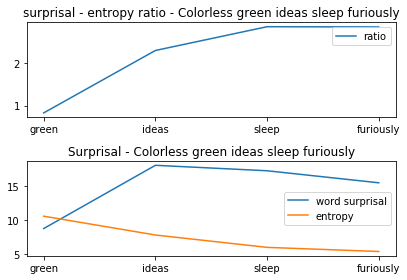

In [1003]:
plot_pp_surp("Colorless green ideas sleep furiously")

surprisals: [13.174370953649301, 4.461405846299406, 13.341142633710955, 10.734929409968881, 10.801669472214947, 2.080531601700281, 1.8677922742157362, 6.827387083914483]
entropies: [11.39662221  7.20367185 10.54350316  6.4717208   5.34557599  5.32673826
  7.02556505  9.56460343]
entropies2: [11.396622206274504, 7.203671849139164, 10.543503158636094, 6.471720801725054, 5.34557599328361, 5.32673826295168, 7.025565053348035, 9.56460343403864, 4.612987218869314]


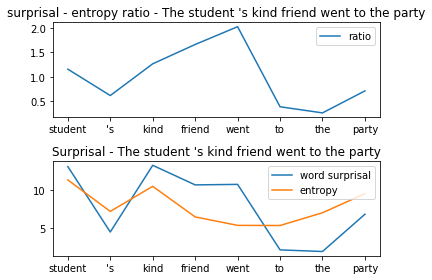

In [1005]:
plot_pp_surp("The student 's kind friend went to the party")

surprisals: [13.174370953649301, 17.193097807307105, 6.4091902597778025, 2.5661917323053873, 4.27512127429933]
entropies: [11.39662221  7.20367185  5.61646062  4.57268734  8.65894441]
entropies2: [11.396622206274504, 7.203671849139164, 5.616460624729071, 4.572687338427569, 8.658944405465443, 4.478640240617037]


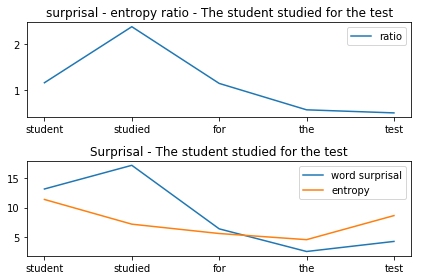

In [1006]:
plot_pp_surp("The student studied for the test")

surprisals: [10.517088300722735, 8.54988836066941, 13.519659572468342, 14.630654128572175, 16.596692625313448]
entropies: [11.39662221  2.13683195  9.01941909  8.9179658   7.76015091]
entropies2: [11.396622206274504, 2.1368319459572818, 9.019419086082946, 8.91796579803147, 7.760150905745792, 7.391293607116127]


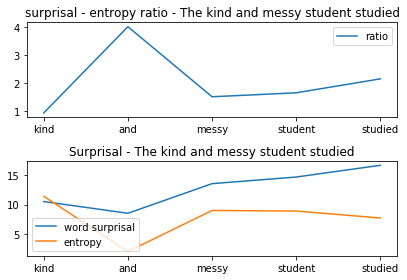

In [1007]:
plot_pp_surp("The kind and messy student studied")

In [738]:
#get_common_pos_continuation("The kind".split(" "))
get_top_k_nw("My friend is so kind and")

My friend is so kind and
	...generous</w> (0.0881)
	...thoughtful</w> (0.0477)
	...kind</w> (0.0403)
	...i</w> (0.0368)
	...considerate</w> (0.0349)
	...understanding</w> (0.0330)
	...caring</w> (0.0322)
	...gentle</w> (0.0316)
	...helpful</w> (0.0278)
	...she</w> (0.0257)


(array([0.08809212, 0.04773878, 0.04030877, 0.03680002, 0.03485625,
        0.0330225 , 0.03215823, 0.03155473, 0.02777886, 0.02571646],
       dtype=float32),
 ['generous',
  'thoughtful',
  'kind',
  'i',
  'considerate',
  'understanding',
  'caring',
  'gentle',
  'helpful',
  'she'],
 [tensor([[[-0.0086, -0.0286, -0.0541,  ...,  0.0464,  0.0357, -0.0256],
           [ 0.3614, -0.3614, -0.3342,  ...,  0.5814, -1.2356, -0.2411],
           [-0.1647,  0.2382, -0.1226,  ...,  0.0735, -0.2093,  0.0489],
           [-0.3308,  0.0640,  0.2596,  ..., -0.1823, -0.2323,  0.3466],
           [-0.3573,  0.6269, -0.8022,  ...,  0.5190, -0.5919,  0.0640],
           [-0.1624, -0.0972,  0.0706,  ..., -0.0395, -0.1114,  0.0139]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0062,  0.0133, -0.0054,  ..., -0.0173,  0.0079, -0.0112],
           [ 0.4003, -0.1457, -0.0099,  ...,  0.3763, -1.2365, -0.2420],
           [-0.3659,  0.4030, -0.1351,  ...,  0.2954, -0.3598,  0.1563],
           [-0.36

surprisals: [12.256484409864395, 12.509049383940894, 6.33147290573264, 2.5389867581000627, 4.229766719029137]
entropies: [11.39662221  7.4155675   5.70820661  5.1321735   8.56205842]
entropies2: [11.396622206274504, 7.415567495129805, 5.7082066072146915, 5.132173500251264, 8.56205841648233, 4.436172272115286]


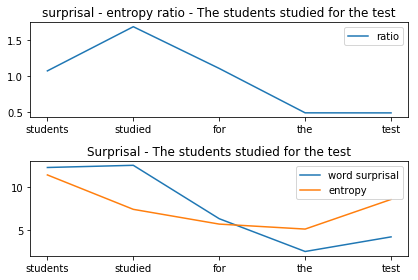

In [1008]:
plot_pp_surp("The students studied for the test")

- Verbs are relatively hard to predict (especially when they come earlier in the sentence and there is not as much relevant information to base predictions off of)
- Nouns have a more pointy distribution compared to verbs
- The aspect keeping the entropy low tends to be high probabilities for punctuation and 


In [676]:
get_top_k_nw("The people")

The people
	...who</w> (0.1245)
	...of</w> (0.1062)
	...in</w> (0.1005)
	....</w> (0.0387)
	...around</w> (0.0357)
	...,</w> (0.0293)
	...i</w> (0.0277)
	...he</w> (0.0269)
	...were</w> (0.0236)
	...on</w> (0.0215)


(array([0.12453286, 0.10615469, 0.10045287, 0.03869786, 0.03566944,
        0.02926273, 0.02767828, 0.0268924 , 0.02358769, 0.02154154],
       dtype=float32),
 ['who', 'of', 'in', '.', 'around', ',', 'i', 'he', 'were', 'on'],
 [tensor([[[ 0.0447, -0.0264, -0.0383,  ...,  0.0381,  0.0374, -0.0235],
           [ 0.4059,  0.1957, -0.4159,  ...,  0.5048, -0.3297, -0.1794]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0022,  0.0156,  0.0020,  ..., -0.0053,  0.0149, -0.0127],
           [ 0.1163,  0.3005, -0.2039,  ...,  0.5609, -0.6005, -0.3513]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0070,  0.0265, -0.0034,  ..., -0.0162,  0.0199, -0.0280],
           [-0.1720,  0.3183, -0.0061,  ...,  0.3099, -0.6133,  0.0261]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0139,  0.0352, -0.0176,  ...,  0.0250,  0.0048, -0.0085],
           [-0.4261,  0.2245,  0.1112,  ...,  0.0095, -0.5079,  0.0732]]],
         grad_fn=<AddBackward0>),
  tensor([[[ 0.0234,  0.0274, -0.0033,  ..., 

In [682]:
text_encoder.encoder.keys()

dict_keys(['.', ',', 't', 'h', 'e', '"', 'o', 'a', 'n', 'd', 'i', 'f', 'w', 's', 'y', 'u', 'r', "'", '?', 'm', 'b', '-', 'v', 'p', 'c', 'l', 'k', 'j', '!', 'g', '*', ';', ':', 'x', 'q', 'z', ')', '(', '1', '/', '_', '2', '3', '4', '~', '5', '#', '0', '6', '7', '$', '>', '9', '8', '[', ']', '<', '&', '%', '¨', '`', 'é', '»', '«', '=', '•', '@', '+', '©', '¡', '{', '}', 'ª', 'ñ', 'ï', '‖', 'ç', 'í', '^', '£', '§', '♥', '−', 'à', '|', '°', '¦', 'ł', 'ĩ', 'ü', '®', 'ù', 'á', 'â', 'ó', 'è', '∞', 'ë', 'ä', '♪', 'ò', 'ω', '▪', '½', 'ǒ', '‡', 'ê', '◊', '►', '۞', 'ú', '€', 'æ', 'î', '↕', 'ô', 'ē', 'ǐ', '♫', '�', '\uf04a', '™', 'ř', 'ā', '·', '¿', '\\', '─', '\uf067', '\uf020', '∙', 'ॐ', 'ö', 'ø', '\uf06c', '\uf09b', '●', '\xad', '■', '\uf063', '†', 'å', 'ō', 'ã', '¤', '⠔', '\uf059', 'н', '\uf09a', '⚔', 'ă', 'û', 'º', '♦', 'ĝ', '¹', '═', '\uf0a3', '¾', 'ì', '☼', 'ș', '¼', '☺', 'đ', 'ą', 'ǽ', '╦', '\uf02a', '¬', 'ī', '\u200b', 'œ', '¢', 'ǎ', 'š', 'ʻ', 'ν', 'α', '\uf05d', 'я', 'б', 'й', 'τ', 'ο', 

In [685]:
"<sos>" in text_encoder.encoder.keys()

False

In [662]:
get_common_pos_continuation("The man knocked".split(" "), k=100)

The man


[('VERB', 0.25791525607928634),
 ('PART', 0.1688386417226866),
 ('PUNCT', 0.08981252054218203),
 ('NOUN', 0.07877727469895035),
 ('ADP', 0.06379612255841494),
 ('PRON', 0.0473697071429342),
 ('ADV', 0.026844590669497848),
 ('CCONJ', 0.013352939859032631),
 ('ADJ', 0.004894230747595429),
 ('DET', 0.0011790419230237603)]

In [664]:
get_top_k_nw("The man")

The man
	...'s</w> (0.1055)
	...who</w> (0.0776)
	...was</w> (0.0595)
	...in</w> (0.0452)
	....</w> (0.0445)
	...,</w> (0.0340)
	...had</w> (0.0282)
	...with</w> (0.0267)
	...said</w> (0.0156)
	...on</w> (0.0140)


(array([0.10548197, 0.07763684, 0.05945616, 0.0452068 , 0.04446416,
        0.03402318, 0.02816702, 0.0267169 , 0.01560371, 0.01400377],
       dtype=float32),
 ["'s", 'who', 'was', 'in', '.', ',', 'had', 'with', 'said', 'on'],
 [tensor([[[ 0.0447, -0.0264, -0.0383,  ...,  0.0381,  0.0374, -0.0235],
           [ 0.2459, -0.0192, -0.3949,  ...,  0.2883, -0.2704, -0.0626]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0022,  0.0156,  0.0020,  ..., -0.0053,  0.0149, -0.0127],
           [ 0.1071, -0.2051, -0.4332,  ...,  0.3419, -0.3340,  0.1220]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0070,  0.0265, -0.0034,  ..., -0.0162,  0.0199, -0.0280],
           [ 0.0485, -0.1816, -0.4708,  ...,  0.0988, -0.3898,  0.2456]]],
         grad_fn=<AddBackward0>),
  tensor([[[-0.0139,  0.0352, -0.0176,  ...,  0.0250,  0.0048, -0.0085],
           [-0.0963, -0.1782, -0.4773,  ..., -0.2449, -0.4810,  0.0139]]],
         grad_fn=<AddBackward0>),
  tensor([[[ 0.0234,  0.0274, -0.0033,  ...,

In [739]:
gp_sents = [
    "The raft floated down the river sank",
    "The horse raced past the barn fell",
    "The child pushed through the crowd cried",
    "The astronaut landed on the moon jumped",
    "The cotton clothing is made of burns",
    "The woman read the story listened",
    "She told me a lie hurts"
]

gp_dis_sents = [
    "The raft that floated down the river sank",
    "The horse that raced past the barn fell",
    "The child that was pushed through the crowd cried",
    "The astronaut that landed on the moon jumped",
    "The cotton that clothing is made of burns",
    "The woman that was read the story listened",
    "She told me that a lie hurts"
]

normal_sentences = [
    "The child wanted to play",
    "The woman on the stairs fell",
    "The lamp on the table shone",
    "The student in class wrote",
]

In [722]:
np.mean([get_surp_entropy_ratio(sent)[-1] for sent in gp_sents])

4.675926260763662

In [723]:
np.mean([get_surp_entropy_ratio(sent)[-1] for sent in gp_dis_sents])

4.028884330864911

In [740]:
np.mean([get_surp_entropy_ratio(sent)[-1] for sent in normal_sentences])

1.64287445695898

surprisals: [8.348754797680032, 6.38215267537104, 0.3313635169923077, 7.469230295253458, 9.176539167980904]
entropies: [11.39662221  7.45086077  1.86594667  6.61990962  6.47611773]
entropies2: [11.396622206274504, 7.450860773876845, 1.8659466730189695, 6.619909623233734, 6.476117726988716, 5.2380880661628675]


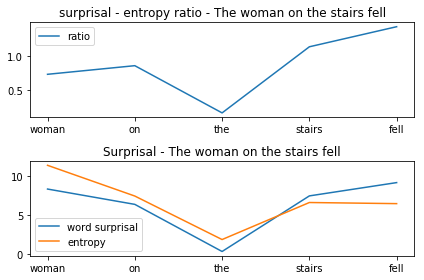

In [1009]:
plot_pp_surp("The woman on the stairs fell")

In [707]:
gp_counts = get_common_pos_continuations(gp_sents, k=100)

In [708]:
gp_dis_counts = get_common_pos_continuations(gp_dis_sents, k=100)

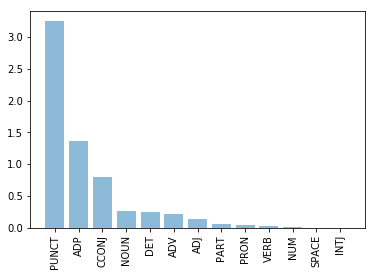

In [709]:
def plot_pos_bar(counts):
    """
    Takes the output from the counter's `most_common` method and turns it
    into a bar plot for easy viewing
    """
    pos, counts = zip(*counts)
    pos = list(pos)
    counts = list(counts)
    pos_ids = np.arange(len(pos))
    plt.bar(pos_ids, counts, align='center', alpha=0.5)
    plt.xticks(pos_ids, pos, rotation = 90)
    plt.show()


plot_pos_bar(gp_counts) # no "that"

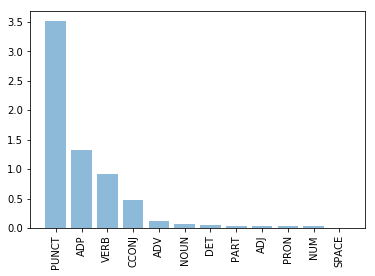

In [710]:
plot_pos_bar(gp_dis_counts) # with "that"

The top plot is the one with the POS counts of the garden path sentences and the bottom one contains the POS counts of the same sentences disambuiated with the word "that" or "that was".

Interestingly, in the bottom plot, we see that the category "VERB" is a very viable option, which is good. These sentences with "that" should have verbs after the relative clause is finished. Despite this, the actual words that follow these sentences have high surprisals!

surprisals: [14.588004337706188, 10.028481880520442, 4.744428645840471, 1.3438441281717053, 1.5140887790304893, 22.616708228267157]
entropies: [11.39662221  5.93922098  6.41928303  3.89752603  6.25746591  4.30953576]
entropies2: [11.396622206274504, 5.939220975718808, 6.419283033264916, 3.897526029454884, 6.257465907148941, 4.309535757977665, 5.899706766759947]


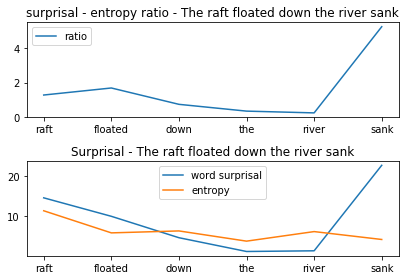

surprisals: [10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]
entropies: [11.39662221  7.2416222   5.44215994  5.2179055  10.40804774  3.47936359]
entropies2: [11.396622206274504, 7.241622197243004, 5.442159941908, 5.2179055045488445, 10.408047738372169, 3.479363588235967, 5.327099568560152]


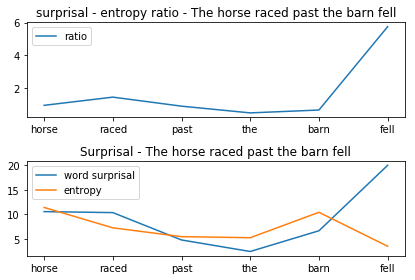

surprisals: [10.536048011641642, 12.399299756015807, 5.1668920851868005, 0.4880913885439432, 3.175904399519657, 21.776954880188796]
entropies: [11.39662221  6.63905898  5.86925197  2.56057443  8.31465061  3.73946223]
entropies2: [11.396622206274504, 6.639058976964765, 5.869251973125947, 2.560574431593309, 8.314650607471252, 3.7394622279550767, 2.6540584978462696]


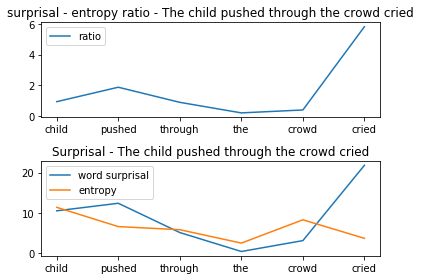

surprisals: [18.76502882772476, 10.827857744880978, 2.7098696115200127, 1.1335058617986198, 3.8016026215090593, 17.46796577038856]
entropies: [11.39662221  8.18688795  4.91204385  4.30861535  8.6332988   3.73777396]
entropies2: [11.396622206274504, 8.18688794743521, 4.912043846898463, 4.308615353965386, 8.633298798976842, 3.737773955325564, 5.931754487952014]


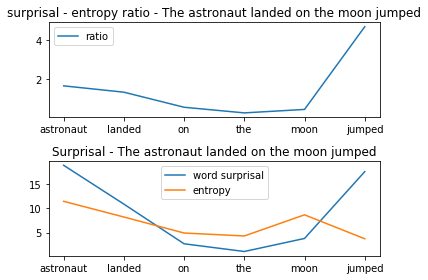

surprisals: [15.170713929549876, 10.081644624485037, 7.865420609875615, 7.155549086445412, 1.004734617678996, 16.616256294172025]
entropies: [11.39662221  8.18989764  6.36468926  9.0220298   2.94858097  8.34423204]
entropies2: [11.396622206274504, 8.189897636830045, 6.36468925903022, 9.02202979922879, 2.948580973829395, 8.344232035672533, 3.46940191645488]


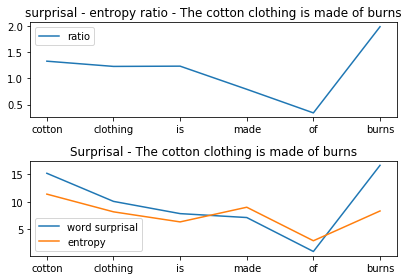

surprisals: [8.348754797680032, 12.413609603582941, 1.8788644454968093, 7.172467434869578, 21.044418285810533]
entropies: [11.39662221  7.45086077  5.49971345  9.50639888  5.17417636]
entropies2: [11.396622206274504, 7.450860773876845, 5.499713451648685, 9.506398879857061, 5.174176355091516, 4.468054522290362]


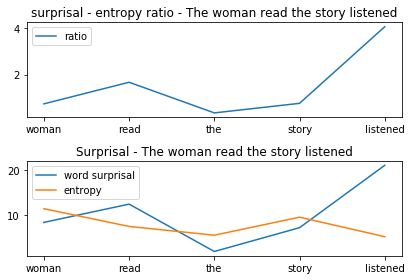

surprisals: [7.273245396777892, 2.0318674364462534, 6.664009741217003, 6.5611623442622, 18.322569711330626]
entropies: [7.42957138 4.16542873 5.18486801 5.99692803 3.53688653]
entropies2: [7.429571383590368, 4.165428726740576, 5.18486801003132, 5.996928034095767, 3.5368865285654483, 4.586591099215322]


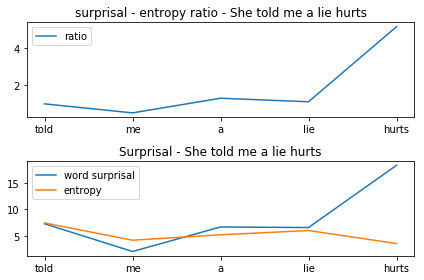

In [1010]:
for sent in gp_sents:
    plot_pp_surp(sent)

Here are some other garden path sentences and sentences with different kinds of verbs: There are short sentences and long sentences and sentences where the garden path effect is more salient than not. Because this

surprisals: [14.588004337706188, 6.941007307371073, 6.807052866154171, 4.930450421103803, 0.8706193395240607, 1.2598701986853358, 17.50700080802177]
entropies: [11.39662221  5.93922098  7.6857869   6.39191677  3.21015111  5.65355706
  4.39133014]
entropies2: [11.396622206274504, 5.939220975718808, 7.6857869018118095, 6.39191676702072, 3.210151106716111, 5.653557055950922, 4.391330138670028, 5.698718603359136]


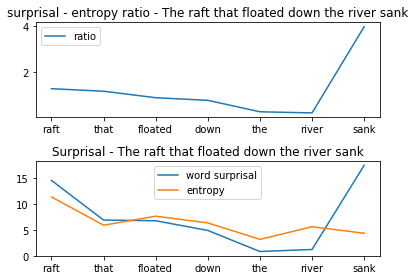

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 5.366152952284609]


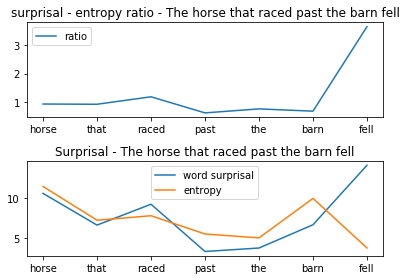

surprisals: [10.536048011641642, 6.665878414829897, 3.7621503771138887, 11.448225214594645, 4.295137219235412, 0.7482363316240589, 7.504579094048283, 16.150768251572877]
entropies: [11.39662221  6.63905898  7.59394678  8.48510381  5.09631779  3.29841878
  7.46957382  4.22117421]
entropies2: [11.396622206274504, 6.639058976964765, 7.593946778967207, 8.485103808599439, 5.0963177913723, 3.2984187838235735, 7.469573824857702, 4.221174205386104, 2.603987499481315]


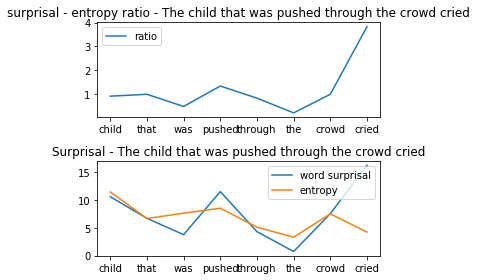

surprisals: [18.76502882772476, 7.301411049287826, 8.834554104879585, 1.6667077270667832, 1.5170583976715175, 1.802748505287217, 13.394940359085416]
entropies: [11.39662221  8.18688795  8.20338172  4.59685502  5.28587717  7.20590129
  4.44308549]
entropies2: [11.396622206274504, 8.18688794743521, 8.20338172485644, 4.596855015450685, 5.285877172607009, 7.205901292546068, 4.443085490567797, 5.219880732061817]


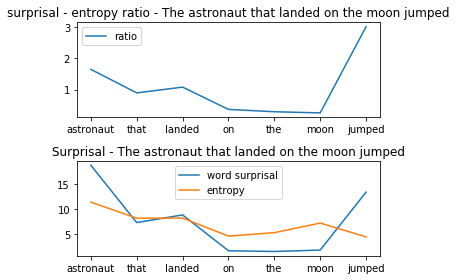

surprisals: [15.170713929549876, 7.606483455756809, 15.518291828342091, 4.877551916298486, 1.8369182261948167, 0.46315662315442657, 17.580718713275107]
entropies: [11.39662221  8.18989764  7.63648787  7.09825086  6.53042351  1.5205095
  2.38219598]
entropies2: [11.396622206274504, 8.189897636830045, 7.636487869005079, 7.0982508556505435, 6.5304235057767785, 1.5205095003341882, 2.3821959760268356, 3.0769470852595036]


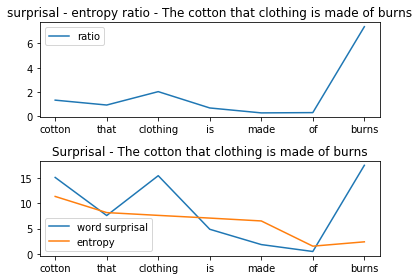

surprisals: [8.348754797680032, 7.531197993566335, 3.8563229874462035, 18.164740334483646, 2.3870337794582395, 6.093159761790509, 17.416161671793013]
entropies: [11.39662221  7.45086077  7.52692569  8.836595    6.03865727  9.55884595
  5.23543613]
entropies2: [11.396622206274504, 7.450860773876845, 7.52692568524384, 8.836594995459421, 6.038657273363747, 9.558845947969397, 5.235436131359904, 4.326102906254021]


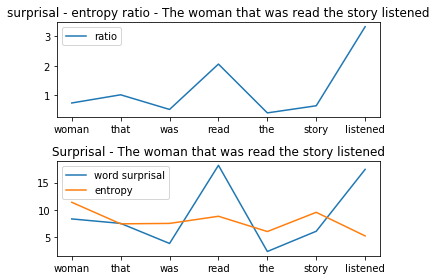

surprisals: [7.273245396777892, 2.0318674364462534, 3.1455342921167415, 6.705784670080099, 11.857424066955016, 13.982311259867753]
entropies: [7.42957138 4.16542873 5.18486801 6.51660947 9.44989727 4.64953194]
entropies2: [7.429571383590368, 4.165428726740576, 5.18486801003132, 6.516609470312277, 9.449897269579505, 4.649531939856634, 4.7712699919312875]


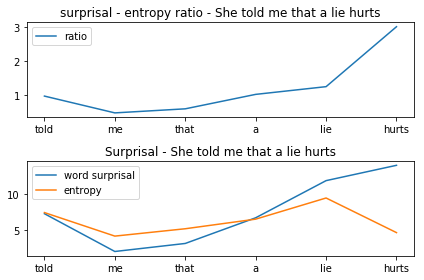

In [1011]:
for sent in gp_dis_sents:
    plot_pp_surp(sent)

surprisals: [10.536048011641642, 12.399299756015807, 5.1668920851868005, 0.4880913885439432, 3.175904399519657, 21.776954880188796, 5.818452952246396, 3.4309558855513, 1.222227585382668]
entropies: [11.39662221  6.63905898  5.86925197  2.56057443  8.31465061  3.73946223
  2.6540585   6.10018626  3.40590347]
entropies2: [11.396622206274504, 6.639058976964765, 5.869251973125947, 2.560574431593309, 8.314650607471252, 3.7394622279550767, 2.6540584978462696, 6.100186257205101, 3.4059034716634935, 2.8625066083973003]


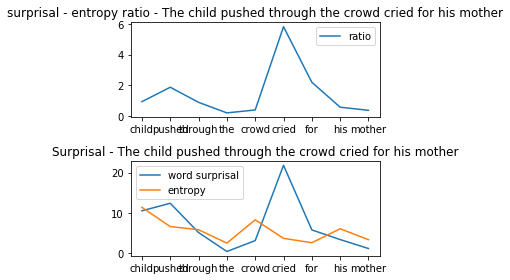

In [1012]:
plot_pp_surp("The child pushed through the crowd cried for his mother")

surprisals: [10.536048011641642, 6.665878414829897, 3.7621503771138887, 11.448225214594645, 4.295137219235412, 0.7482363316240589, 7.504579094048283, 16.150768251572877, 5.648857753102867, 3.680668150921939, 1.1246300055931233]
entropies: [11.39662221  6.63905898  7.59394678  8.48510381  5.09631779  3.29841878
  7.46957382  4.22117421  2.6039875   5.74227559  3.43327469]
entropies2: [11.396622206274504, 6.639058976964765, 7.593946778967207, 8.485103808599439, 5.0963177913723, 3.2984187838235735, 7.469573824857702, 4.221174205386104, 2.603987499481315, 5.742275591550873, 3.4332746878972284, 2.8795928274820097]


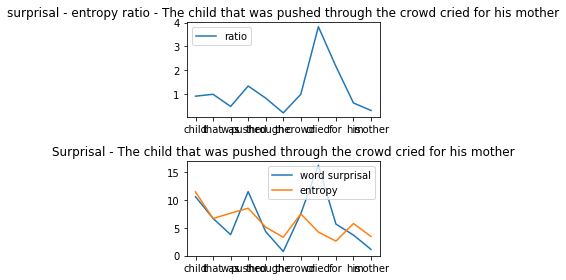

In [1013]:
plot_pp_surp("The child that was pushed through the crowd cried for his mother")

surprisals: [15.175856994991241, 2.939130277107204, 16.038078488587466, 15.02060795110631, 17.312755577523422]
entropies: [7.06145838 4.82715937 3.46935535 2.43765987 7.99284846]
entropies2: [7.061458383480504, 4.827159373009092, 3.469355350539399, 2.43765987155324, 7.992848461811884, 3.6741306353346905]


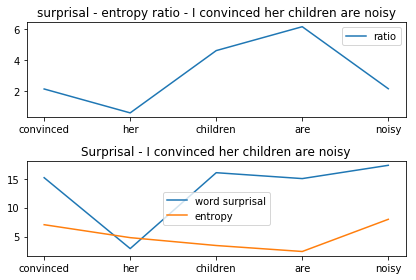

In [1014]:
plot_pp_surp("I convinced her children are noisy")

surprisals: [15.175856994991241, 2.939130277107204, 2.525528337050625, 13.011221714367863, 3.022070466858831, 14.22772650898214]
entropies: [7.06145838 4.82715937 3.46935535 5.82894145 4.96182466 7.11216882]
entropies2: [7.061458383480504, 4.827159373009092, 3.469355350539399, 5.828941446431662, 4.9618246597020415, 7.112168824014306, 2.968329480308831]


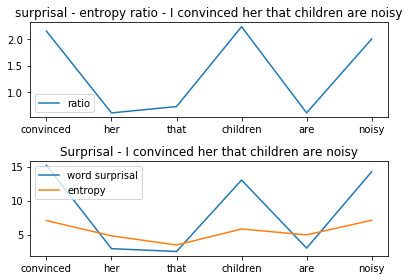

In [1015]:
plot_pp_surp("I convinced her that children are noisy")

surprisals: [12.597701438281176, 11.843719527058653, 2.5037826754590946, 3.6390455126638974, 12.38198547481479, 17.670463266420867, 3.40527629846087, 10.538304740143438]
entropies: [11.39662221  7.09903172  4.53358284  4.69751976  9.54472971  3.65886458
  5.26490149  3.20577153]
entropies2: [11.396622206274504, 7.099031722939975, 4.533582839166144, 4.697519764092673, 9.54472971021923, 3.658864577865264, 5.264901487262915, 3.205771528519115, 3.988411865467751]


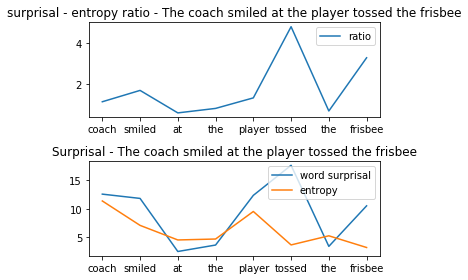

In [1016]:
plot_pp_surp("The coach smiled at the player tossed the frisbee")

surprisals: [11.687681344689212, 10.30089559083253, 3.8854596777847616, 13.90301017186104, 6.277879358030985, 12.010421778549729]
entropies: [11.39662221  6.21022655  5.22661434  8.88368772  3.04169263  9.18188252]
entropies2: [11.396622206274504, 6.21022654503487, 5.226614343912495, 8.88368772108607, 3.0416926295931273, 9.181882523364283, 6.59442630150393]


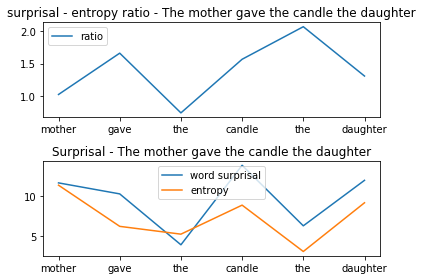

In [1017]:
plot_pp_surp("The mother gave the candle the daughter")

surprisals: [14.588004337706188, 10.028481880520442, 4.744428645840471, 1.3438441281717053, 1.5140887790304893, 22.616708228267157]
entropies: [11.39662221  5.93922098  6.41928303  3.89752603  6.25746591  4.30953576]
entropies2: [11.396622206274504, 5.939220975718808, 6.419283033264916, 3.897526029454884, 6.257465907148941, 4.309535757977665, 5.899706766759947]


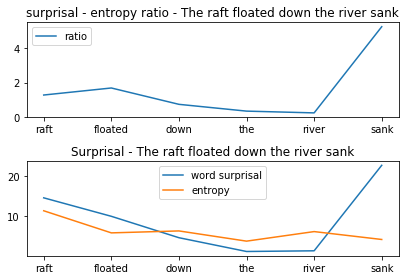

In [1018]:
plot_pp_surp("The raft floated down the river sank")

surprisals: [14.588004337706188, 6.941007307371073, 6.807052866154171, 4.930450421103803, 0.8706193395240607, 1.2598701986853358, 17.50700080802177]
entropies: [11.39662221  5.93922098  7.6857869   6.39191677  3.21015111  5.65355706
  4.39133014]
entropies2: [11.396622206274504, 5.939220975718808, 7.6857869018118095, 6.39191676702072, 3.210151106716111, 5.653557055950922, 4.391330138670028, 5.698718603359136]


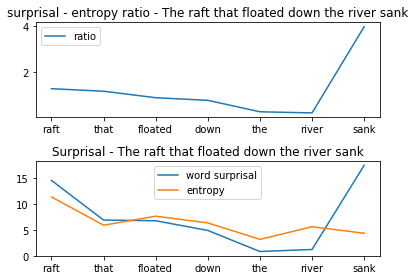

In [1019]:
plot_pp_surp("The raft that floated down the river sank")

surprisals: [14.588004337706188, 11.775819428921805, 6.669458772351034, 2.5752970208730908, 2.8403397338458487, 13.128769476794147]
entropies: [11.39662221  5.93922098  6.08418874  5.17875944  7.26895172  4.70177177]
entropies2: [11.396622206274504, 5.939220975718808, 6.084188738793188, 5.178759442364568, 7.268951723788584, 4.70177177087412, 8.636610402061482]


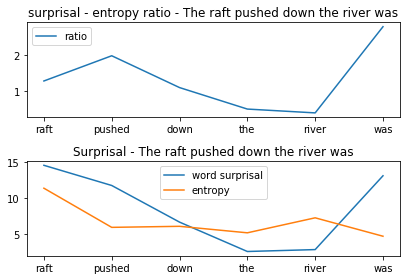

In [1020]:
plot_pp_surp("The raft pushed down the river was")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 5.366152952284609]


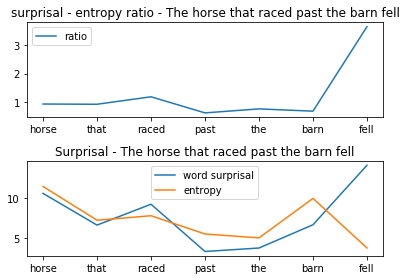

In [1021]:
plot_pp_surp("The horse that raced past the barn fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 20.085768447793253]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 6.00906833112338]


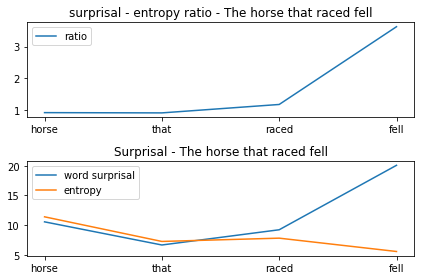

In [1022]:
# shorter sentences
plot_pp_surp("The horse that raced fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 13.490542101415999, 12.450260329564946]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  8.60447946]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 8.604479455101615, 3.3457556957083527]


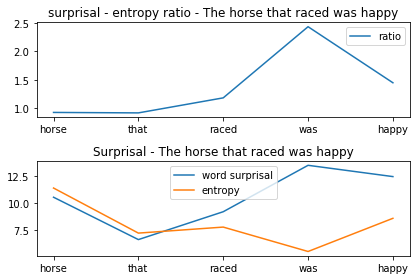

In [1023]:
# Even though, "was" has a much lower surprisal in a later example, it is pretty high here.
plot_pp_surp("The horse that raced was happy")

In [473]:
get_top_k_nw("The horse that raced was")

The horse that raced was
	...a</w> (0.1710)
	...the</w> (0.0615)
	...not</w> (0.0423)
	...n't</w> (0.0303)
	...an</w> (0.0184)
	...one</w> (0.0117)
	...no</w> (0.0100)
	...his</w> (0.0095)
	...very</w> (0.0075)
	...her</w> (0.0071)


(array([0.17096026, 0.06146695, 0.04233985, 0.03031851, 0.01840076,
        0.01166745, 0.01004703, 0.0094907 , 0.00751509, 0.00706884],
       dtype=float32),
 ['a', 'the', 'not', "n't", 'an', 'one', 'no', 'his', 'very', 'her'])

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 10.509985001692916, 16.976106930610467]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.17453457]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.174534569099917, 5.312769580312336]


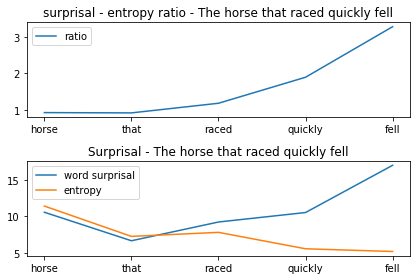

In [1024]:
# slightly longer sentences
plot_pp_surp("The horse that raced quickly fell")

surprisals: [10.54796505332892, 11.5316822250278, 6.801696752989392, 3.057463302078326, 6.137411447177009, 15.110898537573304]
entropies: [11.39662221  7.2416222   7.02510194  5.38508833 10.24186776  3.7887943 ]
entropies2: [11.396622206274504, 7.241622197243004, 7.025101935833056, 5.385088328193632, 10.241867759097977, 3.7887942981256417, 3.73159580240415]


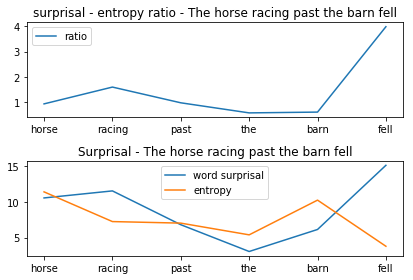

In [1025]:
# different verb form
plot_pp_surp("The horse racing past the barn fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 5.421317047058021, 11.822244553357663]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289  8.70044073]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 8.700440733116624, 3.2791016867928318]


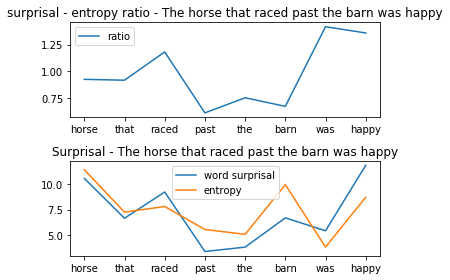

In [1026]:
# different (more common) verb - much better!!!!
plot_pp_surp("The horse that raced past the barn was happy")

surprisals: [10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]
perplexities: [2696.0325628993974, 151.3371317456799, 43.47638077268655, 37.217403537470325, 1358.7343833653244, 11.153028343336652]


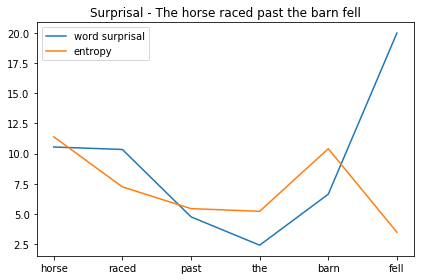

In [750]:
# again using was, what happens to the garden path effect? - it's still there! interesting
plot_pp_surp("The horse raced past the barn was happy")

surprisals: [10.54796505332892, 6.623818161143573, 11.087832549202004, 3.1375518172865897, 11.025737282629757]
entropies: [11.39662221  7.2416222   6.07591336  7.10932308  4.36065721]
entropies2: [11.396622206274504, 7.241622197243004, 6.075913359068032, 7.109323076609753, 4.360657205336234, 5.482901990542702]


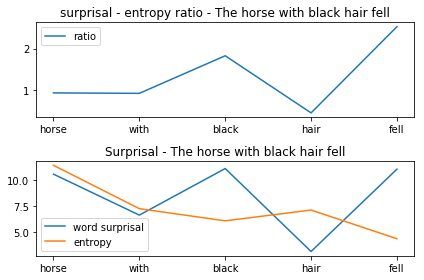

In [1027]:
plot_pp_surp("The horse with black hair fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
perplexities: [2696.0325628993974, 151.3371317456799, 222.2516777071844, 46.74033217217957, 33.62912943000506, 975.0484886984677, 14.171326395798566]


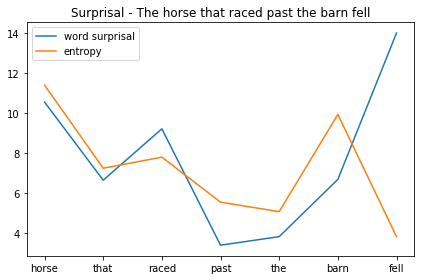

In [751]:
# different verb (also more common) works better
plot_pp_surp("The horse that raced past the barn fell")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 18.138464082786996]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 8.76144419039445]


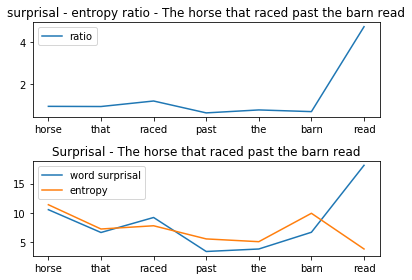

In [1028]:
# trying out non-sensical verb - surprisal even higher
plot_pp_surp("The horse that raced past the barn read")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 17.762160440296952, 10.243846649534559]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289  5.45436746]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 5.454367461547243, 5.009016416135726]


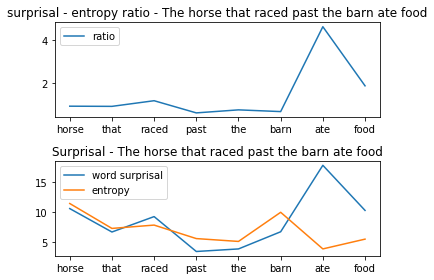

In [1029]:
# trying out different verb with "that", still works though
plot_pp_surp("The horse that raced past the barn ate food")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 11.205809048710197, 8.647707993186394]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289  7.12942366]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 7.1294236610827575, 2.969586216501035]


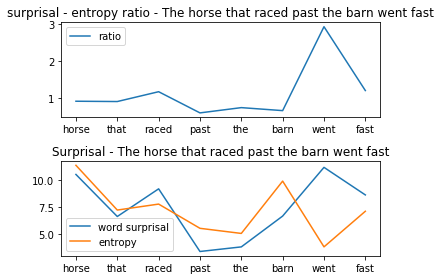

In [1030]:
# Still high surprisal with "that" and somewhat common verb
plot_pp_surp("The horse that raced past the barn went fast")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 11.387457782124299, 6.6947306068199826]
perplexities: [2696.0325628993974, 151.3371317456799, 222.2516777071844, 46.74033217217957, 33.62912943000506, 975.0484886984677, 14.171326395798566, 50.251789802120754]


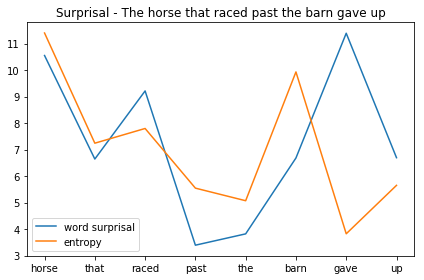

In [464]:
# Still high surprisal with "that" and somewhat common verb
plot_pp_surp("The horse that raced past the barn gave up")

surprisals: [13.673569141303314, 5.3347742643609255, 13.512892554876773, 1.472673936419966, 0.4880675078805312, 5.109258504209382, 20.470446007154454]
perplexities: [2696.0325628993974, 91.49377724343407, 33.38155168059137, 16.056233729585927, 7.708157472347989, 425.471277226707, 16.240349633401934]


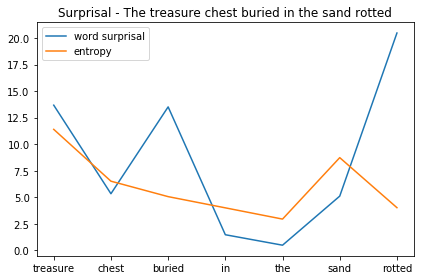

In [646]:
# verbs without garden path effect still have pretty high surprisal
plot_pp_surp("The treasure chest buried in the sand rotted")

surprisals: [13.673569141303314, 5.3347742643609255, 13.512892554876773, 1.472673936419966, 0.4880675078805312, 5.109258504209382, 20.470446007154454]
perplexities: [2696.0325628993974, 91.49377724343407, 33.38155168059137, 16.056233729585927, 7.708157472347989, 425.471277226707, 16.240349633401934]


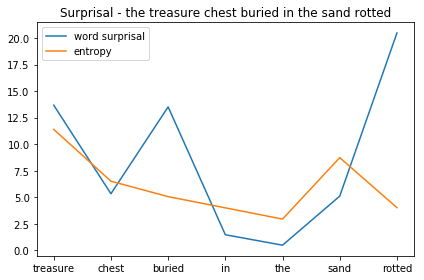

In [754]:
plot_pp_surp("the treasure chest buried in the sand rotted")

It would be interesting to see how the attention weights are distributed among the words the language model is conditioning on. It is a little difficult to do this because there are 12 layers of them and they are not exactly interpretable.

Right now what is being displayed in the plots below is sentences (minus last word) across the top from left to right and layers from (1 to 12, numbered 0-11) from top to bottom. The value of the box is the SUM of all 768 weights in the vector associated with that word. The darker the color of the box, the lower the sum, and the lighter, the higher.

I doubt that the sum makes sense, but there are still some things that are apparent just from this.

First, in the 12th layer for some reason words like "that", "who", and "which" are more positive than the rest of the words. When these words aren't there (in the garden path sentences) other words in the sentence take on slighly lighter colorings

Second, in the 1st layer, the words with the lowest value seem to be the most significant "content" words and also roughly correlate with the peaks in surprisal or entropy (which loosely speaking makes sense as the words that convey the most information SHOULD have the highest surprisal.

In [603]:
_, _, attn_weights = get_top_k_nw("The horse that raced past the barn", 8, False)
# attn_weights has shape (12, 1, len(sentence), 768)
# where 12 is the number of layers (and heads?) and 768 is the size of the embedding

In [604]:
sum_attns = []
for layer in attn_weights:
    l = layer.detach().numpy().squeeze()
    l = l.sum(axis=1)
    sum_attns.append(l)

In [605]:
attn_mat = np.array(sum_attns)

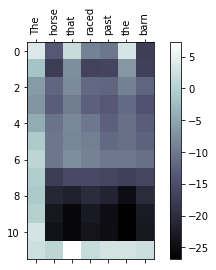

In [606]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(attn_mat, cmap='bone')
fig.colorbar(cax)

ax.set_xticklabels([""]+"The horse that raced past the barn".split(" "), rotation=90)
plt.show()

In [749]:
def plot_attn_thingies(sent):
    """
    Plots "attn weights" versus words for the whole sentence, sent, minus the last word
    """
    sent = " ".join(sent.split(" ")[:-1])
    _, _, attn_weights = get_top_k_nw(sent, 8, False)
    sum_attns = []
    for layer in attn_weights:
        l = layer.detach().numpy().squeeze()
        l = l.mean(axis=1)
        sum_attns.append(l)
    attn_mat = np.array(sum_attns)
    
    # plot it
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attn_mat, cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([""]+sent.split(" "), rotation=90)
    plt.show()

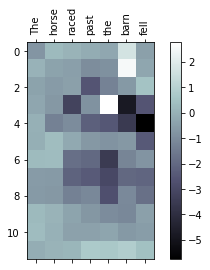

In [748]:
plot_attn_thingies("The horse raced past the barn fell down")

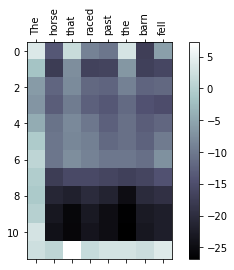

In [638]:
plot_attn_thingies("The horse that raced past the barn fell down")

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648, 6.276182220819285]
perplexities: [2696.0325628993974, 151.3371317456799, 222.2516777071844, 46.74033217217957, 33.62912943000506, 975.0484886984677, 14.171326395798566, 41.245160691526294]


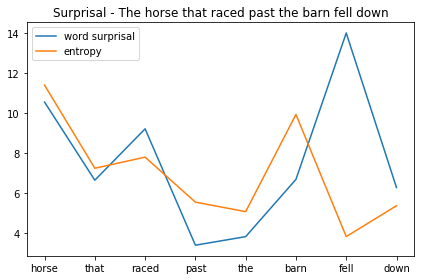

In [639]:
plot_pp_surp("The horse that raced past the barn fell down")

surprisals: [10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455, 6.62002612776695]
perplexities: [2696.0325628993974, 151.3371317456799, 43.47638077268655, 37.217403537470325, 1358.7343833653244, 11.153028343336652, 40.14364098921702]


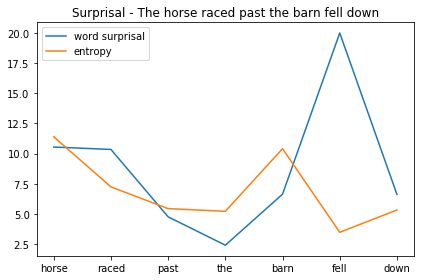

In [640]:
plot_pp_surp("The horse raced past the barn fell down")

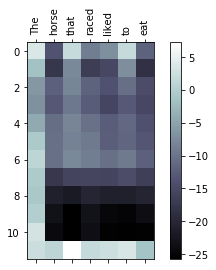

In [620]:
plot_attn_thingies("The horse that raced liked to eat carrots")

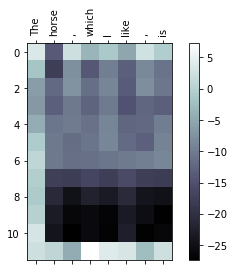

In [624]:
plot_attn_thingies("The horse , which I like , is pretty")

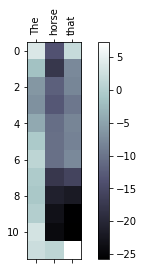

In [610]:
plot_attn_thingies("The horse that raced")

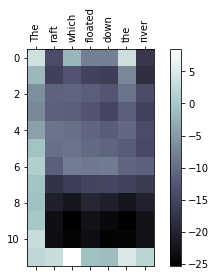

In [613]:
plot_attn_thingies("The raft that floated down the river sank")

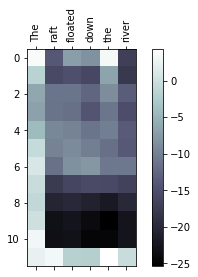

In [612]:
plot_attn_thingies("The raft floated down the river sank")

It appears that the AMOUNT of context can very exremely vary the predictions for the next words:


In [862]:
_, _, _=get_top_k_nw("The horse that raced past the barn")

The horse that raced past the barn
	....</w> (0.3594)
	...,</w> (0.2203)
	...and</w> (0.1462)
	...to</w> (0.0240)
	...was</w> (0.0233)
	...with</w> (0.0160)
	...at</w> (0.0138)
	...in</w> (0.0125)
	...toward</w> (0.0091)
	...as</w> (0.0089)


In [863]:
_, _, _=get_top_k_nw("During the race I went down to the track on the farm. The horse that raced past the barn")

During the race I went down to the track on the farm. The horse that raced past the barn
	...was</w> (0.4598)
	...had</w> (0.0580)
	...and</w> (0.0353)
	...,</w> (0.0351)
	...in</w> (0.0242)
	...looked</w> (0.0224)
	...on</w> (0.0192)
	...at</w> (0.0142)
	...did</w> (0.0120)
	...that</w> (0.0118)


In [875]:
_, _, _=get_top_k_nw("I grew up in a rural area, and I often would go to horse races. During the race I went down to the track on the farm. The horse that raced past the barn")

I grew up in a rural area, and I often would go to horse races. During the race I went down to the track on the farm. The horse that raced past the barn
	...was</w> (0.5476)
	...had</w> (0.0481)
	...on</w> (0.0320)
	...,</w> (0.0300)
	...and</w> (0.0290)
	...in</w> (0.0260)
	...at</w> (0.0176)
	...would</w> (0.0116)
	...that</w> (0.0110)
	...looked</w> (0.0104)


In [866]:
get_common_pos_continuation("The horse that raced past the barn".split(" "))

The horse that raced past the barn


[('PUNCT', 0.5916558347526006),
 ('CCONJ', 0.14834860566770658),
 ('ADP', 0.12878985947463661),
 ('VERB', 0.040052182564977556),
 ('ADV', 0.014772454189369455),
 ('NOUN', 0.01427452708594501),
 ('PART', 0.00614709488581866),
 ('ADJ', 0.0026788056129589677),
 ('DET', 0.0025445548817515373),
 ('PRON', 0.0022127252304926515),
 ('SPACE', 0.0003814685915131122),
 ('NUM', 0.00035079283406957984)]

In [868]:
get_common_pos_continuation("during a race i went down to the track on the farm . the horse that raced past the barn".split(" "))

during a race i went down to the track on the farm . the horse that raced past the barn


[('VERB', 0.673979839833919),
 ('ADP', 0.09014375525293872),
 ('PUNCT', 0.042407130589708686),
 ('CCONJ', 0.03512309491634369),
 ('ADV', 0.019052197982091457),
 ('ADJ', 0.010192023764830083),
 ('DET', 0.004804201191291213),
 ('PRON', 0.003949976060539484),
 ('PART', 0.0035538471420295537),
 ('NOUN', 0.0017274010460823774)]

In [874]:
get_common_pos_continuation("i grew up in a rural area , and i often would go to horse races . during the race i went down to the track on the farm . the horse that raced past the barn".split(" "))

i grew up in a rural area , and i often would go to horse races . during the race i went down to the track on the farm . the horse that raced past the barn


[('VERB', 0.7066978337825276),
 ('ADP', 0.10950294061331078),
 ('PUNCT', 0.03282029030378908),
 ('CCONJ', 0.02900201454758644),
 ('ADV', 0.0261198480729945),
 ('ADJ', 0.006638910621404648),
 ('DET', 0.006562694325111806),
 ('PRON', 0.0049205555114895105),
 ('PART', 0.002512325649149716),
 ('NOUN', 0.0016279657138511539)]

In [910]:

#plot_pp_surp("i grew up in a rural area , and i often would go to horse races . during the race i went down to the track on the farm . the horse that raced past the barn fell")
probs, words, _ =get_top_k_nw("I grew up in a rural area, and I often would go to horse races. During the race I went down to the track on the farm. The horse that raced past the barn", k=100)


I grew up in a rural area, and I often would go to horse races. During the race I went down to the track on the farm. The horse that raced past the barn
	...was</w> (0.5476)
	...had</w> (0.0481)
	...on</w> (0.0320)
	...,</w> (0.0300)
	...and</w> (0.0290)
	...in</w> (0.0260)
	...at</w> (0.0176)
	...would</w> (0.0116)
	...that</w> (0.0110)
	...looked</w> (0.0104)
	...did</w> (0.0073)
	...came</w> (0.0056)
	...to</w> (0.0053)
	...got</w> (0.0052)
	...stopped</w> (0.0051)
	...is</w> (0.0051)
	...took</w> (0.0049)
	...often</w> (0.0048)
	...where</w> (0.0046)
	...i</w> (0.0043)
	...seemed</w> (0.0042)
	...caught</w> (0.0041)
	...gave</w> (0.0041)
	...with</w> (0.0039)
	...next</w> (0.0033)
	...went</w> (0.0032)
	...turned</w> (0.0031)
	...belonged</w> (0.0030)
	...when</w> (0.0029)
	...must</w> (0.0028)
	...always</w> (0.0028)
	...became</w> (0.0027)
	...every</w> (0.0023)
	...made</w> (0.0023)
	...reminded</w> (0.0022)
	...could</w> (0.0022)
	...stood</w> (0.0021)
	...for</w> (0.0021)
	...

In [912]:
len(probs)

100

In [913]:
xxx, probs = get_surprisal("during a race i went down to the track on the farm . the horse that raced past the barn".split(" "))

In [915]:
len(xxx)

19

In [903]:
-np.log2(probs[-1][0][text_encoder.encoder["fell</w>"]].detach().numpy())

11.191364

In [898]:
entropy(probs[-1][0])

4.8865997065045

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]


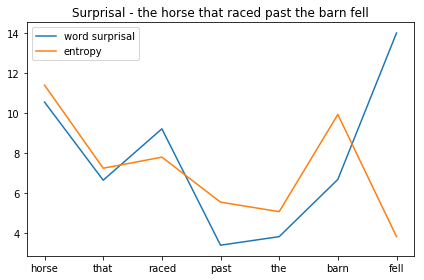

In [906]:
plot_pp_surp("the horse that raced past the barn fell")

In [890]:
len("during a race i went down to the track on the farm . the horse that raced past the barn".split(" "))

20

# Look at variability around verbs versus nouns

In [945]:
def get_surprisals_pos(sent, pos, mask="NOUN"):
    sh_ratios_pos = []
    sh_ratios = get_surp_entropy_ratio(sent) # a bit inefficient
    
    for i in range(len(sh_ratios)):
            
        if pos[i+1] == mask:
            sh_ratios_pos.append(sh_ratios[i])
    
    print(sh_ratios)
    return np.mean(sh_ratios_pos)

In [946]:
get_surprisals_pos("The cow ate the grass", ["DET", "NOUN", "VERB", "DET", "NOUN"])

[1.2159943  1.7079707  0.38572995 0.68772945]


0.9518618720084918

In [952]:
surps, probs = get_surprisal("The cow ate the grass".split(" "))

In [953]:
r1 = surps[0]/entropy(probs[0][0])
r2 = surps[3]/entropy(probs[3][0])

In [954]:
(r1 + r2)/2

0.9518618720084918

In [951]:
surps[3]

12.279355451814514

In [949]:
print(r1, r2)

1.2159942955135246 1.4441052214930654


surprisals: [13.858227590952556, 12.425870092381647, 2.234393488073467, 6.220276737979551]
entropies: [11.39662221  7.27522438  5.79263674  9.04465666]
entropies2: [11.396622206274504, 7.275224383032716, 5.792636735821848, 9.044656661882446, 4.774662446468732]


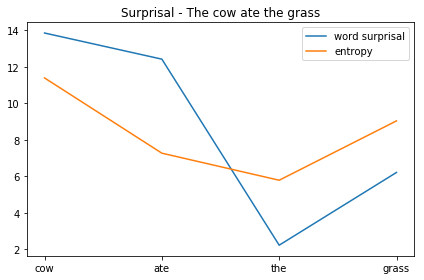

In [938]:
plot_pp_surp("The cow ate the grass")

In [959]:
from nltk import sent_tokenize, word_tokenize

# filename = "/Users/benjaminnewman/Documents/Stanford/CS124/Lectures/Lecture 2 - Unix/nyt_oneline.txt"
# with open(filename, "r") as nyt:
#     doc = nyt.readlines()

# doc = doc[0].strip()
# sents = sent_tokenize(doc)

In [961]:
testnytsent = " ".join(word_tokenize(sents[0]))
testnytpos = ['PROPN',
 'VERB',
 'PROPN',
 'DET',
 'ADJ',
 'ADJ',
 'NOUN',
 'ADV',
 'ADV',
 'VERB',
 'VERB',
 'ADJ',
 'NOUN',
 'ADP',
 'ADJ',
 'NOUN',
 'CCONJ',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'ADJ',
 'NOUN',
 'VERB',
 'VERB',
 'ADP',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'ADP',
 'ADJ',
 'NOUN',
 'PUNCT']

In [963]:
plot_pp_surp(testnytsent.lower())

KeyError: 'downturn</w>'

In [965]:
get_surp_entropy_ratio(testnytsent)

KeyError: 'Friday</w>'

In [967]:
text_encoder.encode([testnytsent])

[[27,
  4672,
  603,
  5513,
  481,
  14175,
  16908,
  2639,
  1300,
  620,
  1311,
  980,
  558,
  909,
  4497,
  504,
  987,
  2006,
  568,
  4597,
  803,
  12810,
  504,
  987,
  3017,
  635,
  580,
  500,
  22847,
  645,
  481,
  2966,
  9463,
  33791,
  666,
  1115,
  1803,
  239]]

In [971]:
text_encoder.encode(["downturn"])

[[2639, 1300]]

In [973]:
text_encoder.decoder[1300]

'turn</w>'

In [974]:
_, _, _ = get_top_k_nw("The", 5)

The
	...door</w> (0.0152)
	...same</w> (0.0128)
	...other</w> (0.0121)
	...first</w> (0.0102)
	...room</w> (0.0095)


(array([0.01518734, 0.01277838, 0.0120944 , 0.01022616, 0.00953439],
       dtype=float32),
 ['door', 'same', 'other', 'first', 'room'],
 [tensor([[[ 3.3483e-02, -2.4465e-03, -3.4837e-02,  6.8242e-02,  1.3805e-01,
            -9.3638e-02,  4.7882e-02,  4.8983e-02, -7.9958e-04,  5.3768e-03,
            -3.2392e-02, -8.5518e-03, -8.4624e-02, -1.0960e-02, -4.2387e-03,
            -5.4296e-02,  1.2117e-01, -6.5958e-02,  5.3364e-02, -2.2163e-02,
            -1.5863e-02,  5.2592e-02,  3.6958e-04, -1.2009e-03,  8.6036e-02,
            -8.3397e-02,  1.5188e-02,  1.5393e-02, -2.5326e-02, -6.1491e-02,
            -4.3184e-02,  2.8794e-02,  1.5589e-01, -6.2586e-02,  2.0791e-01,
             2.5216e-03, -2.5541e-02,  7.4156e-02,  3.0998e-02, -5.8717e-02,
             5.1940e-03,  1.3663e-02,  9.7234e-02, -2.6057e-02,  5.6167e-02,
             5.5561e-02,  1.6423e-02,  5.1032e-02, -5.4735e-02,  3.0421e-02,
             2.0496e-02,  7.3647e-03,  2.7228e-02, -1.7519e-01, -1.3698e-02,
            -1.2

In [975]:
_, _, _ = get_top_k_nw("The door", 5)

The door
	....</w> (0.2520)
	...,</w> (0.1397)
	...and</w> (0.1069)
	...to</w> (0.0755)
	...of</w> (0.0304)


In [976]:
_, _, _ = get_top_k_nw("The door closed", 5)

The door closed
	...behind</w> (0.3464)
	....</w> (0.1985)
	...,</w> (0.1317)
	...and</w> (0.1248)
	...with</w> (0.0356)


In [977]:
_, _, _ = get_top_k_nw("The door closed behind", 5)

The door closed behind
	...him</w> (0.3430)
	...her</w> (0.2275)
	...them</w> (0.1609)
	...me</w> (0.1112)
	...us</w> (0.0463)


In [978]:
_, _, _ = get_top_k_nw("The door closed behind him", 5)

The door closed behind him
	....</w> (0.5310)
	...,</w> (0.2148)
	...and</w> (0.1527)
	...with</w> (0.0251)
	...as</w> (0.0149)


In [979]:
_, _, _ = get_top_k_nw("The door closed behind him when", 5)

The door closed behind him when
	...he</w> (0.4035)
	...i</w> (0.1085)
	...the</w> (0.1016)
	...she</w> (0.0802)
	...his</w> (0.0251)


In [980]:
_, _, _ = get_top_k_nw("The door closed behind him when he", 5)

The door closed behind him when he
	...left</w> (0.0989)
	...turned</w> (0.0633)
	...was</w> (0.0546)
	...heard</w> (0.0525)
	...walked</w> (0.0450)


In [981]:
_, _, _ = get_top_k_nw("The door closed behind him when he returned", 5)

The door closed behind him when he returned
	....</w> (0.3942)
	...to</w> (0.2562)
	...,</w> (0.1437)
	...and</w> (0.0478)
	...with</w> (0.0355)


In [982]:
_, _, _ = get_top_k_nw("The door closed behind him when he returned. He", 5)

The door closed behind him when he returned. He
	...was</w> (0.0884)
	...had</w> (0.0463)
	...sat</w> (0.0444)
	...walked</w> (0.0329)
	...'d</w> (0.0287)


In [983]:
_, _, _ = get_top_k_nw("The door closed behind him when he returned. He was", 5)

The door closed behind him when he returned. He was
	...still</w> (0.0655)
	...wearing</w> (0.0623)
	...n't</w> (0.0560)
	...dressed</w> (0.0398)
	...carrying</w> (0.0380)


surprisals: [6.040987347339556, 5.827015120104707, 1.5296210181894652, 1.543611366013533, 8.886693724940564, 1.3094088978266012, 4.86437164860241, 1.343019198153698, 3.3818422715140635, 3.5000042810504794, 6.769485777641924, 4.385783416244215]
entropies: [11.39662221  5.20345535  3.31504381  3.26551334  2.23508587  4.7834336
  6.51337775  2.84794311  4.26146451  7.45921054  7.94153738  7.28281088]
entropies2: [11.396622206274504, 5.203455345223381, 3.315043813837802, 3.2655133418889375, 2.2350858749139575, 4.783433604695707, 6.513377749817643, 2.847943108076795, 4.261464513408579, 7.4592105432930165, 7.941537381396539, 7.282810879774866, 3.269766940313569]


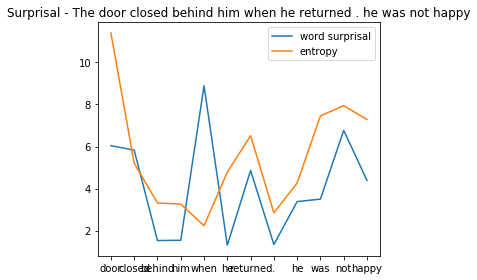

In [984]:
plot_pp_surp("The door closed behind him when he returned . he was not happy")

THESE THINGS ARE TOO BRITTLE! WHY DO THEY ASSIGN SUCH HIGH PROBABILITIES TO SO FEW WORD!

In [989]:
# Uniform probability over vocabulary:
np.log2(vocab - 512)

15.304850388421507

In [1031]:
get_top_k_nw("San Francisco, which has an exotic dancers union and a well-established history of sexual freedom,")

San Francisco, which has an exotic dancers union and a well-established history of sexual freedom,
	...and</w> (0.1572)
	...but</w> (0.0754)
	...is</w> (0.0559)
	...the</w> (0.0502)
	...which</w> (0.0383)
	...a</w> (0.0383)
	..."</w> (0.0304)
	...as</w> (0.0179)
	...in</w> (0.0165)
	...with</w> (0.0156)


(array([0.1572157 , 0.07536831, 0.05591893, 0.05018615, 0.0383415 ,
        0.03826912, 0.0304079 , 0.01791956, 0.01653733, 0.01562342],
       dtype=float32),
 ['and', 'but', 'is', 'the', 'which', 'a', '"', 'as', 'in', 'with'],
 [tensor([[[ 0.1216, -0.0524,  0.0031,  ...,  0.3581, -0.0775, -0.1288],
           [ 0.1049, -0.0495,  0.0365,  ...,  0.2917, -0.0406, -0.1399],
           [ 0.0386, -0.0588,  0.0594,  ...,  0.1404, -0.0068, -0.1027],
           ...,
           [-0.0016,  0.0176,  0.0055,  ...,  0.0340,  0.0019, -0.0327],
           [ 0.0270,  0.0185, -0.0045,  ...,  0.0338,  0.0348, -0.0407],
           [ 0.0405, -0.0144,  0.0325,  ...,  0.0491,  0.0074, -0.0713]]],
         grad_fn=<ViewBackward>),
  tensor([[[ 0.0224,  0.0346, -0.0207,  ...,  0.0379, -0.0894,  0.0355],
           [-0.0087,  0.0488,  0.0045,  ...,  0.0724, -0.0567,  0.0645],
           [-0.0007,  0.0306,  0.0038,  ...,  0.0355, -0.0834,  0.0009],
           ...,
           [ 0.0918,  0.0882, -0.0277,  ...,  

In [1032]:
get_top_k_nw("But Universal, which had an option to become involved because Spielberg started the project there 25 years ago,")

But Universal, which had an option to become involved because Spielberg started the project there 25 years ago,
	...and</w> (0.3454)
	...but</w> (0.0737)
	...when</w> (0.0536)
	...with</w> (0.0428)
	...which</w> (0.0318)
	...in</w> (0.0277)
	...so</w> (0.0219)
	...a</w> (0.0155)
	...after</w> (0.0143)
	...by</w> (0.0142)


(array([0.34541294, 0.07367378, 0.05363745, 0.04284788, 0.03179393,
        0.02769761, 0.02185254, 0.01551735, 0.0142993 , 0.01418958],
       dtype=float32),
 ['and', 'but', 'when', 'with', 'which', 'in', 'so', 'a', 'after', 'by'],
 [tensor([[[ 0.0284, -0.0117, -0.0080,  ..., -0.0501,  0.0500, -0.0411],
           [ 0.0029, -0.0128,  0.0270,  ..., -0.0332,  0.0230, -0.0466],
           [-0.0294, -0.0018,  0.0340,  ...,  0.0170,  0.0095,  0.0014],
           ...,
           [ 0.0310, -0.0458,  0.0026,  ..., -0.0036, -0.0710, -0.0926],
           [ 0.0104, -0.0546, -0.0068,  ..., -0.0060, -0.0467, -0.0479],
           [ 0.0140, -0.0400, -0.0130,  ...,  0.0284, -0.0489, -0.0558]]],
         grad_fn=<ViewBackward>),
  tensor([[[-0.0463, -0.0528, -0.0229,  ...,  0.0085,  0.0090,  0.0118],
           [-0.1336, -0.0039,  0.0490,  ...,  0.0335,  0.0525,  0.0179],
           [-0.1030, -0.0402, -0.0394,  ...,  0.0468,  0.0035, -0.0276],
           ...,
           [ 0.4521, -0.0382, -0.0452,  .

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
entropies: [11.39662221  7.2416222   7.7960505   5.54659608  5.07163953  9.92933015
  3.82490289]
entropies2: [11.396622206274504, 7.241622197243004, 7.796050499316607, 5.546596081927513, 5.071639526642993, 9.92933015496045, 3.824902891610832, 5.366152952284609]


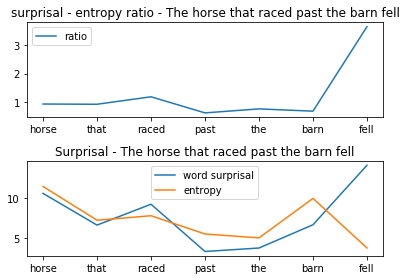

In [1033]:
plot_pp_surp("The horse that raced past the barn fell")

surprisals: [7.889033762218175, 17.06624596116148, 1.9536161737041862]
entropies: [9.0608844  6.69932489 4.50704811]
entropies2: [9.060884401924918, 6.699324886984241, 4.507048113969256, 6.654058964335413]


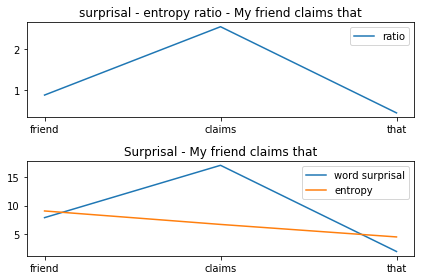

In [1035]:
plot_pp_surp("My friend claims that")

surprisals: [7.889033762218175, 18.960173959908865, 2.6368714481817648]
entropies: [9.0608844  6.69932489 5.49078305]
entropies2: [9.060884401924918, 6.699324886984241, 5.490783052078998, 5.916236788803555]


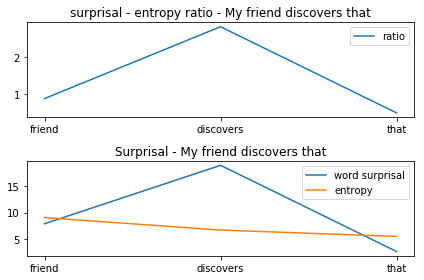

In [1036]:
plot_pp_surp("My friend discovers that")

In [1093]:
probs, words, _ = get_top_k_nw("The horse raced past the barn fell", k=10000, verbose=False)
#probs2, words2, _ = get_top_k_nw("The students", k=10000, verbose=False)
#probs3, words3, _ = get_top_k_nw("The", k=10000, verbose=False)
#probs4, words4, _ = get_top_k_nw("I said that", k=1000, verbose=False)


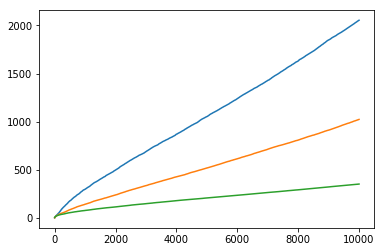

In [1094]:
plt.plot(range(len(words)), probs**-0.5)
plt.plot(range(len(words2)), probs2**-0.5)
plt.plot(range(len(words3)), probs3**-0.5)
#plt.plot(range(len(words4)), 1/probs4)
#plt.plot(range(len(words3)), [vocab]*len(words3))

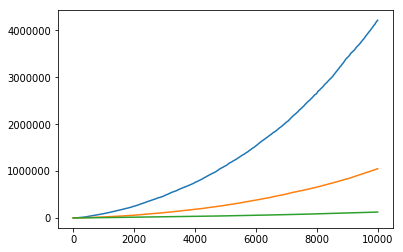

In [1095]:
plt.plot(range(len(words)), probs**-1)
plt.plot(range(len(words2)), probs2**-1)
plt.plot(range(len(words3)), probs3**-1)

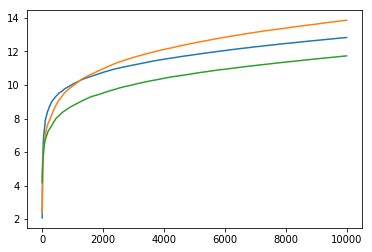

In [1077]:
plt.plot(range(len(words)), np.log(probs**-1))
plt.plot(range(len(words2)), np.log(probs2**-1))
plt.plot(range(len(words3)), np.log(probs3**-1))

In [1049]:
1/vocab

2.439619419370578e-05

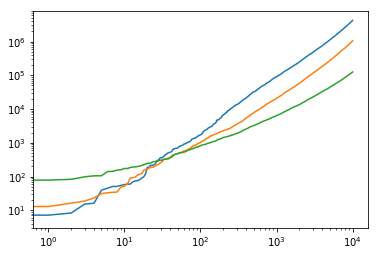

In [1099]:
plt.loglog(range(len(words)), 1/probs)
plt.loglog(range(len(words2)), 1/probs2)
plt.loglog(range(len(words3)), 1/probs3)
#plt.plot(range(len(words4)), 1/probs4)
#plt.plot(range(len(words3)), [vocab]*len(words3))

In [1040]:
probs, words, _ = get_top_k_nw("The students", k=100)

The students
	....</w> (0.0962)
	...,</w> (0.0775)
	...were</w> (0.0617)
	...who</w> (0.0533)
	...and</w> (0.0432)
	...in</w> (0.0319)
	...at</w> (0.0304)
	...had</w> (0.0294)
	...to</w> (0.0290)
	...are</w> (0.0205)
	...'</w> (0.0196)
	...that</w> (0.0162)
	...on</w> (0.0112)
	...would</w> (0.0108)
	...of</w> (0.0104)
	...have</w> (0.0089)
	...from</w> (0.0086)
	...began</w> (0.0082)
	...with</w> (0.0065)
	...around</w> (0.0062)
	...started</w> (0.0061)
	...?</w> (0.0056)
	...as</w> (0.0055)
	...could</w> (0.0053)
	...did</w> (0.0053)
	...he</w> (0.0050)
	...gathered</w> (0.0047)
	...all</w> (0.0045)
	...-</w> (0.0044)
	...looked</w> (0.0040)
	...will</w> (0.0039)
	...i</w> (0.0037)
	...behind</w> (0.0035)
	...walked</w> (0.0031)
	...went</w> (0.0031)
	...took</w> (0.0031)
	...do</w> (0.0029)
	...turned</w> (0.0029)
	...came</w> (0.0028)
	...here</w> (0.0028)
	...or</w> (0.0026)
	...for</w> (0.0026)
	...knew</w> (0.0024)
	...just</w> (0.0024)
	...!</w> (0.0023)
	...they</w> (0.0023)
	

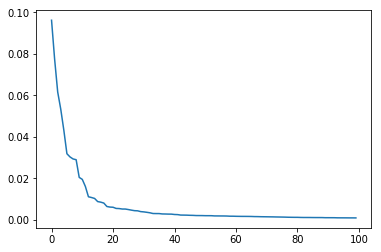

In [1041]:
plt.plot(range(len(words)), probs)

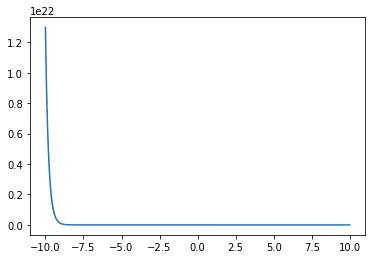

In [1090]:
from scipy.stats import norm, expon
x_axis = np.arange(-10, 10, 0.001)
# Mean = 0, SD = 1.
sorted_norm = 1/np.array(sorted(norm.pdf(x_axis,0,1)))
plt.plot(x_axis, sorted_norm)
plt.show()

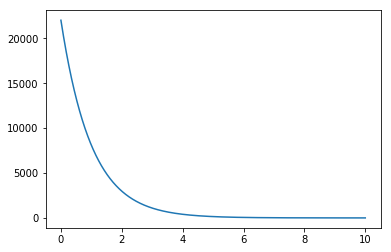

In [1092]:
x = np.arange(0, 10, 0.001)
plt.plot(x, 1/np.array(sorted(expon.pdf(x))))

surprisals: [5.427472425064484, 4.041161554098373, 6.74978486815534, 9.86861494130762, 5.014886308013371, 11.191666779290653, 5.532834917107212, 0.7658190444967073, 11.566503953798836, 1.529030639403866, 10.38516582831503, 5.541592635760531]
entropies: [7.06145838 5.14389687 4.4868546  8.40718914 8.23657736 5.19631331
 2.04206574 2.91187892 3.04471932 3.70912686 9.37418631 2.90181585]
entropies2: [7.061458383480504, 5.143896865421341, 4.486854597203807, 8.407189137074527, 8.23657736394015, 5.196313314679929, 2.042065742306727, 2.9118789244495633, 3.0447193174663236, 3.7091268585110058, 9.374186313429277, 2.9018158479780607, 1.9844139012060253]


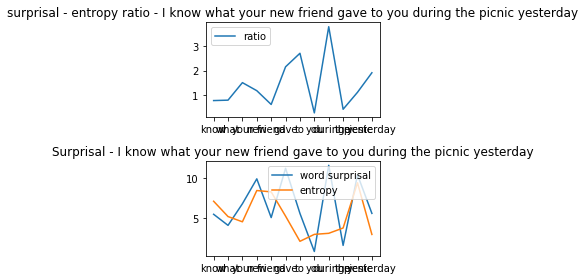

In [1103]:
plot_pp_surp("I know what your new friend gave to you during the picnic yesterday")

surprisals: [8.010499647321227, 6.395035792474785, 1.3581513220136787, 15.014486353149515]
entropies: [7.42957138 4.59003421 3.63016713 5.16894599]
entropies2: [7.429571383590368, 4.590034211677164, 3.630167134525258, 5.1689459935074895, 3.778922004374658]


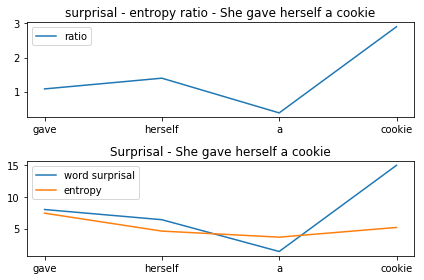

In [1104]:
plot_pp_surp("She gave herself a cookie")

surprisals: [8.010499647321227, 10.5991548222545, 1.0012877787280594, 15.175110093614254]
entropies: [7.42957138 4.59003421 3.6777038  6.37590092]
entropies2: [7.429571383590368, 4.590034211677164, 3.6777037973859326, 6.375900916265396, 3.884086113349131]


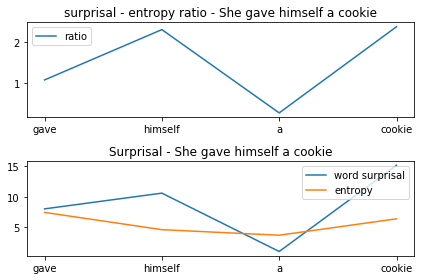

In [1105]:
plot_pp_surp("She gave himself a cookie")

surprisals: [10.073686086611549, 7.34605688908619, 9.108731001228358, 0.8153820370152907, 14.050288860646585]
entropies: [11.39662221  7.18391054  4.43676822  3.49142821  7.98166325]
entropies2: [11.396622206274504, 7.1839105419539, 4.436768223443537, 3.4914282113889126, 7.981663251305358, 3.6758813718236527]


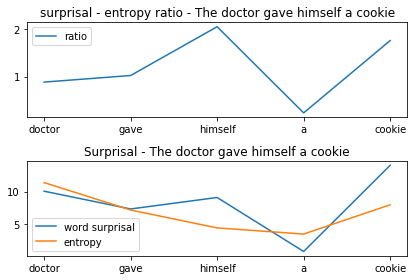

In [1106]:
plot_pp_surp("The doctor gave himself a cookie")

surprisals: [10.073686086611549, 7.34605688908619, 11.54247120092415, 0.8627667957615406, 13.635508358399044]
entropies: [11.39662221  7.18391054  4.43676822  3.6646935   7.51872111]
entropies2: [11.396622206274504, 7.1839105419539, 4.436768223443537, 3.6646935008633497, 7.518721107467692, 3.6063525390620104]


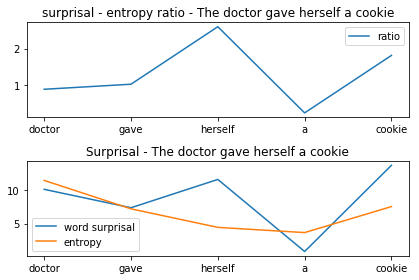

In [1107]:
plot_pp_surp("The doctor gave herself a cookie")

surprisals: [10.073686086611549, 7.34605688908619, 2.6515122616719204, 4.095946558097675, 4.800319867997413]
entropies: [11.39662221  7.18391054  4.43676822  4.83968592  8.16433232]
entropies2: [11.396622206274504, 7.1839105419539, 4.436768223443537, 4.839685923339637, 8.16433232408227, 3.481479206088333]


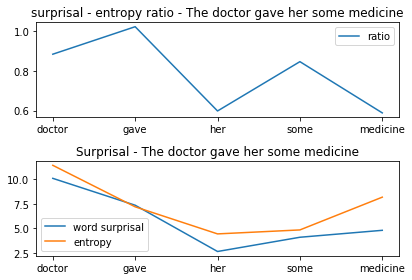

In [1108]:
plot_pp_surp("The doctor gave her some medicine")

surprisals: [10.073686086611549, 7.34605688908619, 2.2263251150917904, 4.110243265813857, 5.225622917330833]
entropies: [11.39662221  7.18391054  4.43676822  4.53404298  8.52373288]
entropies2: [11.396622206274504, 7.1839105419539, 4.436768223443537, 4.534042976852209, 8.523732881978017, 3.4775419027456036]


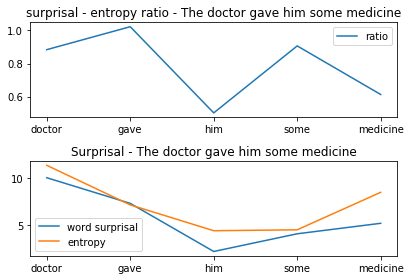

In [1109]:
plot_pp_surp("The doctor gave him some medicine")

surprisals: [10.073686086611549, 7.34605688908619, 9.108731001228358, 6.252406459228437, 8.433384516424443]
entropies: [11.39662221  7.18391054  4.43676822  3.49142821  7.19995878]
entropies2: [11.396622206274504, 7.1839105419539, 4.436768223443537, 3.4914282113889126, 7.199958779868561, 3.569099012746839]


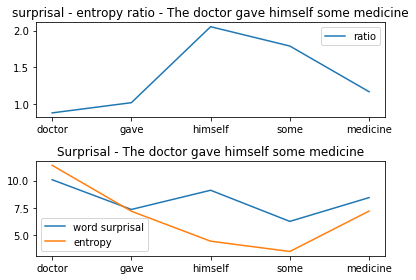

In [1110]:
plot_pp_surp("The doctor gave himself some medicine")